In [2]:
# This file is modified from Jordan
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

In [8]:
# Load labels

sp_ratings = pd.read_excel('./dataset/labels.xlsx', sheet_name='sp-ratings')
label2rating = {
    0: 'AAA',
    1: 'AA+',
    2: 'AA',
    3: 'AA-',
    4: 'A+',
    5: 'A',
    6: 'A-',
    7: 'BBB+',
    8: 'BBB',
    9: 'BBB-',
    10: 'BB+',
    11: 'BB',
    12: 'BB-',
    13: 'B+',
    14: 'B',
    15: 'B-',
    16: 'CCC+',
    17: 'CCC',
    18: 'CCC-',
    19: 'CC',
    20: 'C',
    21: 'D',
}
rating2label = dict((v,k) for k,v in label2rating.items())
rating2label['SD'] = 21

print(sp_ratings.head())

   Unnamed: 0 2016Q4 2016Q3 2016Q2 2016Q1 2015Q4 2015Q3 2015Q2 2015Q1 2014Q4  \
0        1045    BB-    BB-    BB-    BB-    BB-    BB-    BB-     B+     B+   
1        1075     A-     A-     A-     A-     A-     A-     A-     A-     A-   
2        1078     A+     A+     A+     A+     A+     A+     A+     A+     A+   
3        1166    BB+    BB+    BB+    BB+    BB+    BB+    BB+    BB+    BB+   
4        1177     A-     A-     A-      A      A      A      A      A      A   

   ... 2014Q1 2013Q4 2013Q3 2013Q2 2013Q1 2012Q4 2012Q3 2012Q2 2012Q1 2011Q4  
0  ...      B      B      D      D      D      D      D      D      D      D  
1  ...     A-     A-   BBB+   BBB+   BBB+   BBB+    BBB    BBB    BBB    BBB  
2  ...     A+     A+     A+     A+     A+     A+     AA     AA     AA     AA  
3  ...     BB     BB     BB     BB    BB-    BB-    BB-    BB-    BB-    BB-  
4  ...     A-     A-     A-     A-     A-     A-     A-     A-     A-     A-  

[5 rows x 22 columns]


In [9]:
# Select appropriate quarters

q4_ratings = sp_ratings[['2014Q4', '2015Q4', '2016Q4']]
q4_labels = q4_ratings.replace(rating2label)
q4_labels[~q4_labels['2015Q4'].isin(label2rating.keys())]

print(q4_labels.head())

   2014Q4  2015Q4  2016Q4
0      13      12      12
1       6       6       6
2       4       4       4
3      10      10      10
4       5       5       6


In [5]:
# Load features

df_14q4 = pd.read_csv('./dataset/2014Q4.csv')
df_14q4.fillna(df_14q4.mean(), inplace=True)

df_15q4 = pd.read_csv('./dataset/2015Q4.csv')
df_15q4.fillna(df_15q4.mean(), inplace=True)

df_16q4 = pd.read_csv('./dataset/2016Q4.csv')
df_16q4.fillna(df_16q4.mean(), inplace=True)

In [6]:
df_14q4 = pd.read_csv('./dataset/2014Q4.csv').fillna(0)
df_15q4 = pd.read_csv('./dataset/2015Q4.csv').fillna(0)
df_16q4 = pd.read_csv('./dataset/2016Q4.csv').fillna(0)

print(df_14q4.head())

   Assets - Total      Cash  Debt in Current Liabilities - Total  \
0       43771.000   994.000                              1708.00   
1       14313.532     7.604                               530.97   
2       41275.000  4063.000                              4437.00   
3        2210.772   466.829                                 0.00   
4       53402.100  1420.400                               729.30   

   Long-Term Debt - Total  Earnings Before Interest  Gross Profit (Loss)  \
0               16196.000                  6585.000            13139.000   
1                3031.215                  1228.600             1228.600   
2                3408.000                  4475.000            12088.000   
3                   0.000                   134.767              308.828   
4                7852.000                  4848.700            15091.500   

   Liabilities - Total  Retained Earnings  Total debt/total asset  \
0            41750.000         -13121.000                0.370017

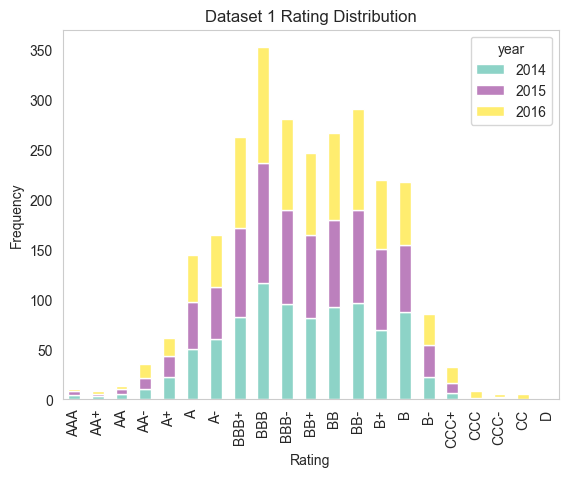

(2703, 23)


In [42]:
# MLP train/test split
from sklearn.utils import resample
from resample import random_oversample, smote_oversample, visualise_samples

def upsample(df, seed=1, factor=1000):
  grouped = df.groupby('label')
  mx_cnt = max(grouped.size())
  upsampled = []
  for label in grouped.groups.keys():
    upsampled.append(resample(
      df.loc[grouped.groups[label]],
      replace=True,
      n_samples=min(mx_cnt, len(grouped.groups[label]) * factor),
      random_state=seed
    ))
  return pd.concat(upsampled)

def merge(x, y):
  return pd.concat([x, y], axis=1)

def unmerge(df):
  x = torch.from_numpy(df.drop(columns=['label']).values)
  y = torch.from_numpy(df['label'].values)
  return x, y


# Split parameters
seed = 1
frac = 0.8



df_14q4['year'] = '2014' # add a new column
df_15q4['year'] = '2015'
df_16q4['year'] = '2016'
# xs = pd.concat([df_14q4, df_15q4, df_16q4], ignore_index=True).astype('float32')
xs = pd.concat([df_14q4, df_15q4, df_16q4], ignore_index=True) # vertically concat and reset index
ys = q4_labels.melt(value_name='label').drop('variable', axis=1)
df = pd.concat([xs, ys], axis=1) # horizontally concat

import matplotlib.cm as cm
select = (0.1, 0.5, 0.3)
cmap = cm.Set3
colors = cmap(np.linspace(0, 1.5, 3))
# Plot distribution of dataset
dfp = df[['label', 'year']].pivot_table(index=['label'], columns=['year'], aggfunc=len)
ax = dfp.plot(kind='bar', stacked=True, color=colors, ylabel='Frequency', xlabel='Rating')
# ax = df.groupby('label').size().plot(kind='bar', xlabel='Rating')
ax.set_xticklabels([label2rating[key] for key in df.groupby('label').groups.keys()])

plt.title('Dataset 1 Rating Distribution')
plt.grid(False)
plt.show()
# visualise_samples(df, 'tsne', seed)
df = df.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share']).astype('float32')

print(df.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#print(df.head())
df_scaled = scaler.fit_transform(df.drop(columns=['label']))
df_scaled = pd.DataFrame(df_scaled, columns = df.drop(columns=['label']).columns)
#print(df_2.head())
df = pd.concat([df_scaled, df['label']], axis=1)
#print(df)

In [ ]:
df.to_csv('./dataset/data.csv', index=False)

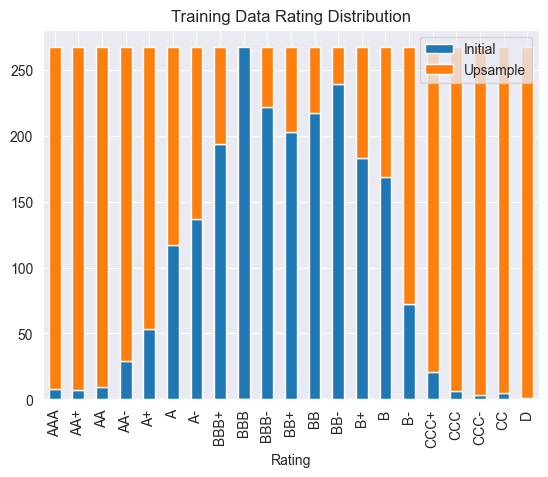

(5607, 23)
torch.Size([5607, 22])
torch.Size([5607])
torch.Size([541, 22])
torch.Size([541])


In [63]:
# Split for n-fold cross-validation
df_shuffle = df.sample(frac=0.8, random_state=seed)
chunks = np.array_split(df_shuffle, round(1 / (1 - frac)))
folds = []
for i in range(len(chunks)):
  train = []
  for j in range(len(chunks)):
    if i != j:
      train.append(chunks[j])
  train = pd.concat(train) # list to DataFrame
  train = random_oversample(train, seed=seed)
  x_train, y_train = unmerge(train)
  x_test, y_test = unmerge(chunks[i])
  folds.append((x_train, y_train, x_test, y_test))

train = df.sample(frac=frac, random_state=seed)
test = df.drop(train.index) # drop data samples used in training set

x_test, y_test = unmerge(test)

train_dist = train.groupby('label').size() # label distribution in training setmain.ipynb

# Upsample training data
train = random_oversample(train, seed=seed)
# train = smote_oversample(train, seed=seed)

# Plot distribution of train data
upsampled_dist = train.groupby('label').size() - train_dist

ax = pd.concat([train_dist, upsampled_dist], keys=['Initial', 'Upsample'], axis=1).plot(kind='bar', stacked=True, xlabel='Rating')
ax.set_xticklabels([label2rating[key] for key in train.groupby('label').groups.keys()])
plt.title('Training Data Rating Distribution')
plt.show()
# visualise_samples(train, 'tsne', seed=seed)

x_train, y_train = unmerge(train)

print(train.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [34]:
torch.save(x_train, './dataset/X_train_mlp.pt')
torch.save(y_train, './dataset/y_train_mlp.pt')
torch.save(x_test,'./dataset/X_test_mlp.pt')
torch.save(y_test, './dataset/y_test_mlp.pt')

torch.Size([5607])
torch.Size([5607, 22])


In [35]:
x_test = torch.load('./dataset/X_test_mlp.pt')
y_test = torch.load('./dataset/y_test_mlp.pt')
x_train = torch.load('./dataset/X_train_mlp.pt')
y_test = torch.load('./dataset/y_train_mlp.pt')

In [15]:
# Define visualise confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(preds, y, title='Confusion Matrix'):
  labels = list(rating2label.keys())[:-1]
  # Plotting the confusion matrix
  cm = confusion_matrix(y, preds, normalize='all', labels=list(range(22)))
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  # sns.heatmap(cm, annot=True, ax = ax)
  sns.heatmap(cm, annot=False, ax = ax, cmap=sns.light_palette([240, 75, 50], input='husl', as_cmap=True))

  # labels, title and ticks
  ax.set_xlabel('Predicted ratings')
  ax.set_ylabel('True ratings')
  ax.set_title(title)
  ax.xaxis.set_ticklabels(labels, rotation=70)
  ax.yaxis.set_ticklabels(labels, rotation=0)
  plt.show()

In [6]:
# Define ordinal criterion
from net_archs import MLP, LSTMModel

def ordinal_criterion(predictions, targets):
  # Ordinal regression with encoding as in https://arxiv.org/pdf/0704.1028.pdf

  # Create out modified target with [batch_size, num_labels] shape
  modified_target = torch.zeros_like(predictions)

  # Fill in ordinal target function, i.e. 0 -> [1,0,0,...]
  for i, target in enumerate(targets):
    modified_target[i, 0:int(target)+1] = 1

  return nn.MSELoss(reduction='none')(predictions, modified_target).sum(axis=1)


In [7]:
# Define train and test function
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, f1_score

def train(net, optimizer, x, y, num_epoch=256, batch_size=16, criterion=ordinal_criterion):
  print_every = -1

  for n in range(num_epoch):
    # Mini batch sgd
    permutation = torch.randperm(x.size()[0])
    for i in range(0, x.size()[0], batch_size):
      indices = permutation[i:i+batch_size]
      x_mini, y_mini = x[indices], y[indices]
      y_pred = net(x_mini)
      loss = criterion(y_pred.float(), y_mini.float()) # default criterion = ordinal_criterion
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()
      if print_every != -1 and (i / batch_size) % print_every == 0:
        print(f'Epoch: {n + 1}, Iteration: {round(i / batch_size)}, Loss: {loss.sum()}')
    if print_every == -1:
      print(f'Epoch: {n + 1}, Loss: {loss.sum()}')

def prediction2label(pred: np.ndarray):
  """Convert ordinal predictions to class labels, e.g.
  
  [0.9, 0.1, 0.1, 0.1] -> 0
  [0.9, 0.9, 0.1, 0.1] -> 1
  [0.9, 0.9, 0.9, 0.1] -> 2
  etc.
  """
  return (pred > 0.5).cumprod(axis=1).sum(axis=1) - 1

def test(net, x_test, y_test):
  y_pred = net(x_test)
  if y_pred.shape[1] == 21:
    y_pred = prediction2label(net(x_test))
  else:
    y_pred = torch.clip(y_pred.round(), min=0, max=21)

  y_default_test = np.where(y_test.detach().numpy() > 9, 1, 0)
  y_default_pred = np.where(y_pred.detach().numpy() > 9, 1, 0)
  mse = mean_squared_error(y_test.detach().numpy(), y_pred.detach().numpy())
  mse_norm = mean_squared_error(y_test.detach().numpy() / 21, y_pred.detach().numpy() / 21)
  auc = roc_auc_score(y_default_test, y_default_pred)
  f1 = f1_score(y_default_test, y_default_pred)
  return mse, mse_norm, auc, f1


### MLP

In [39]:
# 5 fold cross validation
mses = []
mse_norms = []
aucs = []
f1s = []
for x_train, y_train, x_test, y_test in folds:
  model = MLP(22, 21)
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
  train(model, optimizer, x_train, y_train)
  mse, mse_norm, auc, f1 = test(model, x_test, y_test)
  mses.append(mse)
  mse_norms.append(mse_norm)
  aucs.append(auc)
  f1s.append(f1)

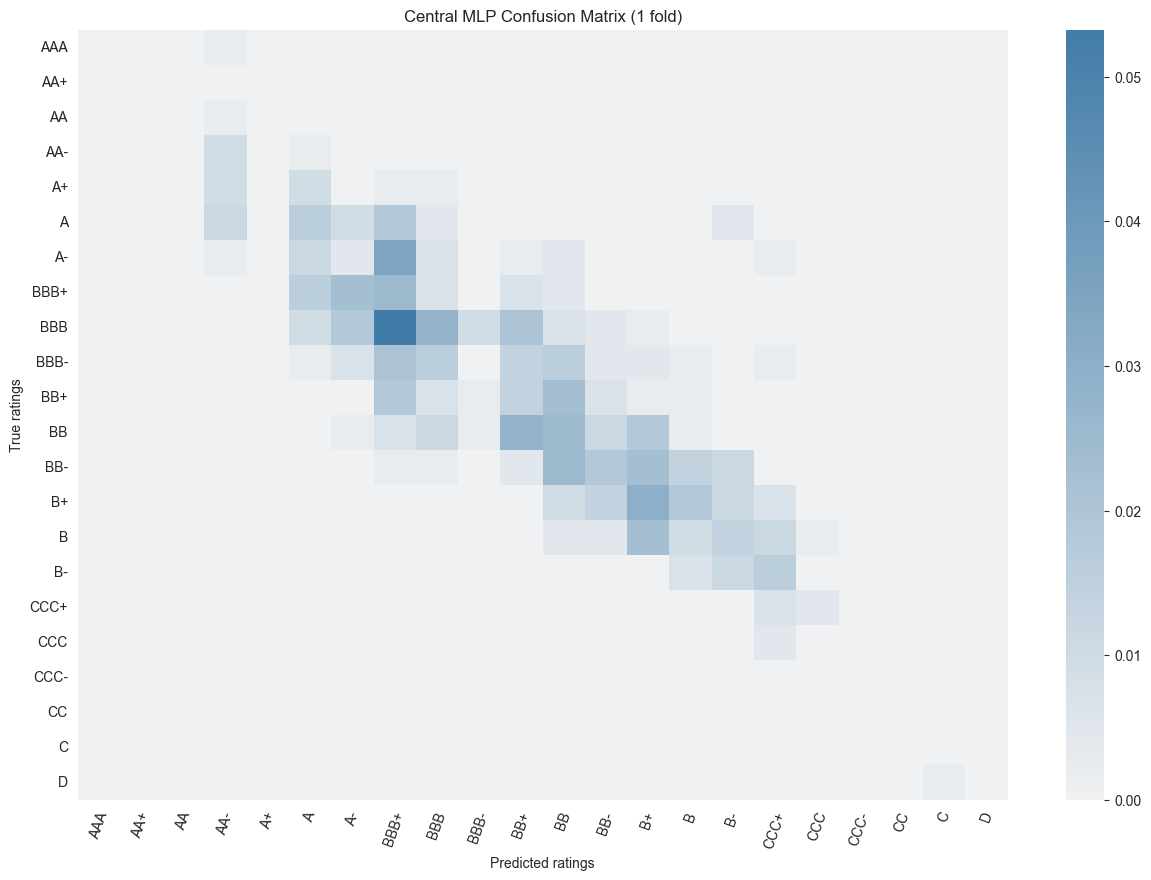

In [16]:
# Visualise confusion matrix for one fold
_, _, x_test, y_test = folds[-1]
y_pred = prediction2label(model(x_test))
confusion(y_pred, y_test, 'Central MLP Confusion Matrix (1 fold)')

In [ ]:
# Print 5 fold cross validation statistics
import statistics

print(statistics.mean(mses))
print(statistics.stdev(mses))
print(statistics.mean(mse_norms))
print(statistics.stdev(mse_norms))
print(statistics.mean(aucs))
print(statistics.stdev(aucs))
print(statistics.mean(f1s))
print(statistics.stdev(f1s))

In [ ]:
# Define loss convergence graph visualistion for FL
def plot_loss(losses, start=0, title='Diagram'):
  assert len(losses) >= 6
  a, b, c, d, e, f, *_ = losses
  plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
  plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
  plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
  plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
  plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
  plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
  plt.xticks(range(start, len(a)+1, 5))
  plt.legend()
  plt.xlabel('Aggregation Round')
  plt.ylabel('MSE Loss')
  plt.title(title)
  plt.show() 

In [ ]:
# Plot FL convergence
plot_loss([[(1, 5.66913123844732), (2, 3.5489833641404807), (3, 3.0314232902033273), (4, 2.9149722735674675), (5, 2.741219963031423), (6, 2.563770794824399), (7, 2.5415896487985212), (8, 2.4510166358595193), (9, 2.425138632162662), (10, 2.33086876155268), (11, 2.4824399260628467), (12, 2.4177449168207024), (13, 2.476894639556377), (14, 2.410351201478743), (15, 2.4085027726432533)]
, [(1, 3.301293900184843), (2, 2.922365988909427), (3, 2.8170055452865066), (4, 2.7837338262476896), (5, 2.8539741219963033), (6, 3.3844731977818854), (7, 2.837338262476895), (8, 2.9537892791127542), (9, 2.931608133086876), (10, 2.846580406654344), (11, 2.966728280961183), (12, 2.870609981515712), (13, 2.8780036968576708), (14, 2.7948243992606283), (15, 2.8022181146025877)]
, [(1, 4.693160813308688), (2, 3.955637707948244), (3, 3.229205175600739), (4, 3.192236598890943), (5, 3.077634011090573), (6, 3.301293900184843), (7, 3.11090573012939), (8, 3.147874306839187), (9, 3.044362292051756), (10, 3.1848428835489835), (11, 2.8946395563770797), (12, 3.1515711645101665), (13, 3.0073937153419594), (14, 3.090573012939002), (15, 2.9926062846580406), (16, 2.9944547134935307), (17, 2.9981515711645104), (18, 3.033271719038817), (19, 2.8946395563770797), (20, 2.8817005545286505), (21, 2.866913123844732), (22, 2.844731977818854), (23, 2.8872458410351203), (24, 2.720887245841035), (25, 2.6284658040665434), (26, 2.7634011090573014), (27, 2.744916820702403), (28, 2.88909426987061), (29, 2.8354898336414047), (30, 2.733826247689464)]
, [(1, 4.918669131238447), (2, 5.728280961182994), (3, 3.3493530499075788), (4, 2.9371534195933457), (5, 2.7190388170055453), (6, 2.7264325323475047), (7, 2.9390018484288354), (8, 3.081330868761553), (9, 2.822550831792976), (10, 2.9611829944547137), (11, 2.5914972273567467), (12, 2.746765249537893), (13, 2.9593345656192236), (14, 2.7597042513863217), (15, 2.7356746765249538), (16, 2.6968576709796674), (17, 2.731977818853974), (18, 2.678373382624769), (19, 2.689463955637708), (20, 2.7689463955637708), (21, 2.7948243992606283), (22, 2.711645101663586), (23, 2.6635859519408505), (24, 2.6487985212569316), (25, 2.77449168207024), (26, 2.711645101663586), (27, 2.5804066543438076), (28, 2.5175600739371533), (29, 2.689463955637708), (30, 2.6524953789279113)]
, [(1, 6.748613678373383), (2, 3.9353049907578557), (3, 3.7948243992606283), (4, 3.870609981515712), (5, 3.6340110905730127), (6, 3.1848428835489835), (7, 3.3031423290203326), (8, 3.2310536044362292), (9, 3.467652495378928), (10, 3.1072088724584104), (11, 3.042513863216266), (12, 3.3068391866913123), (13, 3.243992606284658), (14, 3.2458410351201477), (15, 3.0739371534195934), (16, 3.0499075785582255), (17, 3.133086876155268), (18, 3.0850277264325325), (19, 3.168207024029575), (20, 3.1053604436229203), (21, 3.2070240295748613), (22, 3.014787430683919), (23, 2.8484288354898335), (24, 2.9057301293900184), (25, 3.009242144177449), (26, 2.9963031423290203), (27, 3.014787430683919), (28, 3.011090573012939), (29, 2.918669131238447), (30, 2.9371534195933457), (31, 2.9279112754158967), (32, 2.898336414048059), (33, 2.77818853974122), (34, 3.0055452865064693), (35, 2.78003696857671), (36, 2.789279112754159), (37, 3.0499075785582255), (38, 2.9057301293900184), (39, 2.9149722735674675), (40, 2.9704251386321627), (41, 2.77818853974122), (42, 2.866913123844732), (43, 2.9704251386321627), (44, 2.833641404805915), (45, 2.709796672828096), (46, 2.720887245841035), (47, 2.9205175600739373), (48, 2.8410351201478745), (49, 2.7375231053604434), (50, 2.8687615526802217), (51, 2.8502772643253236), (52, 3.0369685767097967), (53, 2.9020332717190387), (54, 2.689463955637708), (55, 3.011090573012939), (56, 2.6913123844731976), (57, 2.7541589648798523), (58, 2.765249537892791), (59, 2.7966728280961184), (60, 2.798521256931608)]
, [(1, 7.040665434380776), (2, 3.720887245841035), (3, 3.720887245841035), (4, 4.003696857670979), (5, 3.9981515711645104), (6, 4.32532347504621), (7, 4.452865064695009), (8, 4.512014787430684), (9, 4.432532347504621), (10, 3.243992606284658), (11, 3.4140480591497226), (12, 3.4805914972273566), (13, 3.3567467652495377), (14, 3.521256931608133), (15, 2.8188539741219962), (16, 2.8207024029574863), (17, 2.985212569316081), (18, 2.7504621072088726), (19, 2.846580406654344), (20, 2.733826247689464), (21, 2.865064695009242), (22, 2.7153419593345656), (23, 2.6395563770794825), (24, 2.7504621072088726), (25, 2.6284658040665434), (26, 2.5194085027726434), (27, 2.6044362292051755), (28, 2.5175600739371533), (29, 2.5249537892791127), (30, 2.632162661737523), (31, 2.578558225508318), (32, 2.4473197781885396), (33, 2.5286506469500925), (34, 2.532347504621072), (35, 2.6432532347504623), (36, 2.598890942698706), (37, 2.5471349353049906), (38, 2.312384473197782), (39, 2.545286506469501), (40, 2.6099815157116453), (41, 2.4842883548983363), (42, 2.33086876155268), (43, 2.3955637707948245), (44, 2.707948243992606), (45, 2.410351201478743), (46, 2.512014787430684), (47, 2.358595194085028), (48, 2.5378927911275415), (49, 2.3844731977818854), (50, 2.3715341959334566), (51, 2.5489833641404807), (52, 2.6340110905730127), (53, 2.3733826247689462), (54, 2.312384473197782), (55, 2.432532347504621), (56, 2.4842883548983363), (57, 2.5175600739371533), (58, 2.378927911275416), (59, 2.3900184842883547), (60, 2.33086876155268)]]
, start=0, title='')

In [54]:
# Define MLP FL simulation wrapper
from fl_simu import mlp_simulation


def run_simulation(split, dir='default', num_epoch=2, batch_size=16, num_rounds=15):
    return mlp_simulation(split, x_train, y_train, x_test, y_test, dir, num_epoch, batch_size, num_rounds)


In [55]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', batch_size=128, num_epoch=1, num_rounds=1)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

INFO flwr 2023-07-25 12:02:01,829 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-07-25 12:02:23,769	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-07-25 12:02:32,049 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1195890279.0, 'object_store_memory': 597945139.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-25 12:02:32,051 | server.py:89 | Initializing global parameters
INFO flwr 2023-07-25 12:02:32,052 | server.py:276 | Requesting initial parameters from one random client
INFO flwr 2023-07-25 12:02:35,509 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-07-25 12:02:35,509 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-07-25 12:02:35,509 | server.py:104 | FL starting
DEBUG flwr 2023-07-25 12:02:35,510 | server.py:222 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 20

Saving round 1 aggregated_parameters...
102.3068391866913
0.5


In [ ]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

In [ ]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

In [ ]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

In [ ]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

In [ ]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

In [ ]:
# Plot non stratified FL MLP convergence
plot_loss([[(1, 15.835489833641406), (2, 7.22735674676525), (3, 6.1090573012939), (4, 5.77818853974122), (5, 5.449168207024029), (6, 5.388170055452865), (7, 6.574861367837339), (8, 5.759704251386322), (9, 5.321626617375231), (10, 4.728280961182994), (11, 5.312384473197782), (12, 4.279112754158965), (13, 4.678373382624769), (14, 4.290203327171904), (15, 4.249537892791127), (16, 4.190388170055453), (17, 4.279112754158965), (18, 4.094269870609981), (19, 4.136783733826248), (20, 4.12014787430684), (21, 4.480591497227357), (22, 4.031423290203327), (23, 3.9741219963031424), (24, 3.8817005545286505), (25, 4.022181146025878), (26, 3.975970425138632), (27, 4.116451016635859), (28, 3.876155268022181), (29, 3.866913123844732), (30, 3.789279112754159), (31, 3.698706099815157), (32, 3.8262476894639557), (33, 3.7541589648798523), (34, 3.6617375231053604), (35, 4.279112754158965), (36, 3.7486136783733826), (37, 3.798521256931608), (38, 3.645101663585952), (39, 3.6765249537892792), (40, 3.6598890942698707), (41, 3.6173752310536043), (42, 3.6672828096118297), (43, 3.5914972273567467), (44, 3.4491682070240297), (45, 3.43992606284658), (46, 3.5175600739371533), (47, 3.436229205175601), (48, 3.310536044362292), (49, 3.622920517560074), (50, 3.391866913123845), (51, 3.3364140480591495), (52, 3.22550831792976), (53, 3.325323475046211), (54, 3.4085027726432533), (55, 3.177449168207024), (56, 3.3234750462107208), (57, 3.2070240295748613), (58, 3.3512014787430684), (59, 3.3271719038817005), (60, 3.345656192236599)]
, [(1, 18.120147874306838), (2, 6.7744916820702406), (3, 7.3290203327171906), (4, 6.754158964879852), (5, 6.569316081330869), (6, 5.972273567467653), (7, 5.809611829944547), (8, 6.0258780036968576), (9, 4.402957486136784), (10, 4.118299445471349), (11, 4.580406654343808), (12, 4.072088724584104), (13, 3.789279112754159), (14, 3.743068391866913), (15, 4.033271719038817), (16, 3.6672828096118297), (17, 4.2181146025878), (18, 3.2957486136783736), (19, 3.1515711645101665), (20, 3.162661737523105), (21, 3.1848428835489835), (22, 3.4473197781885396), (23, 3.3401109057301293), (24, 3.086876155268022), (25, 3.2828096118299444), (26, 3.8964879852125693), (27, 3.412199630314233), (28, 3.009242144177449), (29, 3.0850277264325325), (30, 3.024029574861368), (31, 2.988909426987061), (32, 2.8188539741219962), (33, 3.044362292051756), (34, 2.909426987060998), (35, 2.9611829944547137), (36, 3.243992606284658), (37, 2.981515711645102), (38, 2.946395563770795), (39, 3.166358595194085), (40, 3.186691312384473), (41, 2.8022181146025877), (42, 3.0295748613678373), (43, 3.020332717190388), (44, 3.075785582255083), (45, 2.8946395563770797), (46, 2.9963031423290203), (47, 2.9149722735674675), (48, 2.744916820702403), (49, 2.7504621072088726), (50, 3.2033271719038816), (51, 2.855822550831793), (52, 3.1127541589648797), (53, 3.0295748613678373), (54, 2.6728280961182995), (55, 2.7634011090573014), (56, 2.678373382624769), (57, 2.942698706099815), (58, 2.7042513863216264), (59, 2.744916820702403), (60, 2.804066543438078)]
, [(1, 15.791127541589649), (2, 16.58410351201479), (3, 15.800369685767098), (4, 11.133086876155268), (5, 5.837338262476894), (6, 5.77264325323475), (7, 27.88909426987061), (8, 5.249537892791127), (9, 19.994454713493532), (10, 14.325323475046211), (11, 4.717190388170056), (12, 10.380776340110906), (13, 14.149722735674677), (14, 4.650646950092422), (15, 4.513863216266174), (16, 11.199630314232902), (17, 14.060998151571164), (18, 4.567467652495379), (19, 13.67837338262477), (20, 16.08133086876155), (21, 16.234750462107208), (22, 4.12014787430684), (23, 9.711645101663587), (24, 4.188539741219963), (25, 13.208872458410351), (26, 14.164510166358594), (27, 15.900184842883549), (28, 14.266173752310536), (29, 15.608133086876155), (30, 4.194085027726432), (31, 10.696857670979668), (32, 13.744916820702404), (33, 14.43253234750462), (34, 15.619223659889094), (35, 16.611829944547136), (36, 16.44731977818854), (37, 4.44362292051756), (38, 4.510166358595194), (39, 4.011090573012939), (40, 3.985212569316081), (41, 12.09796672828096), (42, 14.573012939001849), (43, 13.133086876155268), (44, 13.903881700554528), (45, 16.275415896487985), (46, 15.617375231053604), (47, 16.944547134935306), (48, 15.920517560073938), (49, 16.859519408502774), (50, 4.11090573012939), (51, 12.099815157116451), (52, 3.8354898336414047), (53, 11.898336414048059), (54, 12.54713493530499), (55, 3.842883548983364), (56, 10.035120147874308), (57, 12.850277264325323), (58, 14.249537892791128), (59, 3.942698706099815), (60, 11.292051756007394)]
, [(1, 19.99260628465804), (2, 5.817005545286507), (3, 6.269870609981516), (4, 50.96487985212569), (5, 9.818853974121996), (6, 7.240295748613678), (7, 50.96487985212569), (8, 50.96487985212569), (9, 50.96487985212569), (10, 50.96487985212569), (11, 4.878003696857671), (12, 5.1589648798521255), (13, 50.96487985212569), (14, 50.96487985212569), (15, 4.323475046210721), (16, 50.93345656192236), (17, 5.271719038817006), (18, 5.199630314232902), (19, 6.953789279112754), (20, 6.081330868761553), (21, 50.96487985212569), (22, 12.55822550831793), (23, 50.96487985212569), (24, 11.384473197781885), (25, 4.3622920517560075), (26, 50.75600739371534), (27, 50.96487985212569), (28, 14.463955637707949), (29, 50.96487985212569), (30, 9.953789279112755), (31, 6.314232902033272), (32, 5.166358595194085), (33, 4.959334565619224), (34, 5.6044362292051755), (35, 4.303142329020333), (36, 5.754158964879852), (37, 4.979667282809612), (38, 4.2014787430683915), (39, 4.038817005545287), (40, 4.181146025878004), (41, 4.354898336414048), (42, 5.56007393715342), (43, 4.565619223659889), (44, 5.040665434380776), (45, 3.8207024029574863), (46, 50.44547134935305), (47, 9.092421441774492), (48, 4.626617375231054), (49, 4.611829944547135), (50, 3.567467652495379), (51, 4.624768946395564), (52, 50.82809611829945), (53, 50.96487985212569), (54, 50.96487985212569), (55, 50.96487985212569), (56, 12.101663585951941), (57, 8.177449168207024), (58, 6.129390018484289), (59, 5.641404805914973), (60, 4.142329020332717)]
, [(1, 84.09796672828097), (2, 10.354898336414047), (3, 29.432532347504623), (4, 7.2199630314232905), (5, 39.173752310536045), (6, 39.64879852125693), (7, 6.726432532347505), (8, 9.166358595194085), (9, 50.96487985212569), (10, 9.173752310536045), (11, 11.469500924214417), (12, 5.103512014787431), (13, 41.975970425138634), (14, 4.811460258780037), (15, 41.78373382624769), (16, 44.975970425138634), (17, 50.927911275415894), (18, 41.59519408502773), (19, 4.942698706099815), (20, 10.903881700554528), (21, 33.20147874306839), (22, 4.881700554528651), (23, 36.39741219963032), (24, 42.11460258780037), (25, 8.194085027726432), (26, 4.658040665434381), (27, 6.131238447319778), (28, 38.54158964879852), (29, 11.179297597042513), (30, 28.373382624768947), (31, 4.682070240295749), (32, 35.05360443622921), (33, 36.3271719038817), (34, 15.362292051756008), (35, 4.77634011090573), (36, 15.467652495378928), (37, 16.382624768946396), (38, 22.953789279112755), (39, 4.292051756007393), (40, 4.266173752310536), (41, 17.179297597042513), (42, 3.9020332717190387), (43, 4.079482439926063), (44, 4.456561922365989), (45, 29.824399260628464), (46, 36.7634011090573), (47, 26.364140480591498), (48, 43.56007393715342), (49, 48.033271719038815), (50, 4.133086876155268), (51, 4.1256931608133085), (52, 12.009242144177449), (53, 41.40480591497227), (54, 29.155268022181147), (55, 4.550831792975971), (56, 4.136783733826248), (57, 15.611829944547136), (58, 24.737523105360445), (59, 26.99815157116451), (60, 24.951940850277264)]
, [(1, 56.96118299445472), (2, 14.33826247689464), (3, 14.293900184842883), (4, 29.32902033271719), (5, 10.878003696857672), (6, 8.467652495378928), (7, 7.811460258780037), (8, 7.194085027726432), (9, 20.637707948243992), (10, 7.022181146025878), (11, 46.44177449168207), (12, 5.375231053604436), (13, 64.67837338262477), (14, 53.438077634011094), (15, 12.767097966728281), (16, 6.639556377079482), (17, 5.792975970425139), (18, 4.0924214417744915), (19, 22.073937153419593), (20, 36.781885397412196), (21, 3.746765249537893), (22, 3.7615526802218113), (23, 16.54898336414048), (24, 7.1922365988909425), (25, 4.262476894639557), (26, 11.179297597042513), (27, 38.52310536044362), (28, 50.76524953789279), (29, 4.977818853974122), (30, 3.7726432532347505), (31, 4.573012939001848), (32, 3.837338262476895), (33, 36.23290203327172), (34, 9.702402957486136), (35, 25.303142329020332), (36, 29.358595194085026), (37, 38.160813308687615), (38, 6.683918669131239), (39, 4.837338262476894), (40, 37.06099815157116), (41, 37.63401109057301), (42, 4.079482439926063), (43, 22.10720887245841), (44, 4.053604436229205), (45, 3.2846580406654344), (46, 40.676524953789276), (47, 39.50277264325324), (48, 7.046210720887246), (49, 6.377079482439926), (50, 45.345656192236596), (51, 11.020332717190389), (52, 3.388170055452865), (53, 37.1460258780037), (54, 48.181146025878), (55, 34.8373382624769), (56, 58.06284658040666), (57, 29.852125693160815), (58, 4.521256931608133), (59, 62.593345656192234), (60, 14.761552680221811)]]
, start = 0, title = 'Non stratified across workers')

mses = [3.345656192236599,
2.804066543438078,
11.292051756007394,
4.142329020332717,
24.951940850277264,
14.761552680221811]

aucs = [0.8703482791718087,
0.8431783902372137,
0.5,
0.815843959961607,
0.5087412587412588,
0.5384615384615384]

### LSTM

In [8]:
# Transform to time series
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

df_14q4_mod = df_14q4.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share'], inplace=False, errors='ignore')
df_15q4_mod = df_15q4.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share'], inplace=False, errors='ignore')
df_16q4_mod = df_16q4.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share'], inplace=False, errors='ignore')
df_14q4_mod = (df_14q4_mod-df_14q4_mod.mean())/df_14q4_mod.std()
df_15q4_mod = (df_15q4_mod-df_15q4_mod.mean())/df_15q4_mod.std()
df_16q4_mod = (df_16q4_mod-df_16q4_mod.mean())/df_16q4_mod.std()
df_14q4_mod['label'] = q4_labels['2014Q4']
df_15q4_mod['label'] = q4_labels['2015Q4']
df_16q4_mod['label'] = q4_labels['2015Q4']

ts14 = torch.tensor(df_14q4_mod.values.astype('float32'))
ts15 = torch.tensor(df_15q4_mod.values.astype('float32'))
ts16 = torch.tensor(df_16q4_mod.values.astype('float32'))
ts = torch.stack([ts14, ts15, ts16], 1)

ts_labels = q4_labels['2016Q4']

In [9]:
print(ts.shape)

torch.Size([901, 3, 23])


In [10]:
# 5 fold cross validation
mses = []
mse_norms = []
aucs = []
f1s = []

kf = KFold(n_splits=5)
for i, (train_idx, test_idx) in enumerate(kf.split(ts, ts_labels)):
  X_train = ts[train_idx]
  X_test = ts[test_idx]
  print(X_train.shape)
  y_train = torch.reshape(torch.tensor(ts_labels)[train_idx], (-1, 1))
  y_test = torch.reshape(torch.tensor(ts_labels)[test_idx], (-1, 1))
  lstm = LSTMModel(23, 21)
  optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0001, weight_decay=0.00001)
  train(lstm, optimizer, X_train, y_train, batch_size=6, num_epoch=20)

  y_pred = prediction2label(lstm(X_test))
  #confusion(y_pred, y_test, f'Central LSTM Confusion Matrix (1 Fold)')
  mse, mse_norm, auc, f1 = test(lstm, X_test, y_test)
  mses.append(mse)
  mse_norms.append(mse_norm)
  aucs.append(auc)
  f1s.append(f1)

torch.Size([720, 3, 23])


KeyboardInterrupt: 

In [17]:
# Print 5 fold cross validation statistics
import statistics

print(mses)
print(statistics.mean(mses))
print(statistics.stdev(mses))
print(statistics.mean(mse_norms))
print(statistics.stdev(mse_norms))
print(statistics.mean(aucs))
print(statistics.stdev(aucs))
print(statistics.mean(f1s))
print(statistics.stdev(f1s))

[0.9467849223946785, 1.0755555555555556]
1.011170238975117
0.0910545879257415
0.0022929030362247547
0.0002064729884937452
0.9555041026421748
0.013327430518980377
0.9636028891091915
0.010014258337155515


In [133]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(ts, ts_labels, test_size=0.2, random_state=1)
y_train = torch.reshape(torch.tensor(y_train.values), (-1, 1))
y_test = torch.reshape(torch.tensor(y_test.values), (-1, 1))

In [134]:
# Define LSTM FL simulation wrapper
from fl_simu import lstm_simulation

def run_lstm_simulation(split, dir='default', num_epoch=256, batch_size=16, num_rounds=15):
    return lstm_simulation(split, X_train, y_train, X_test, y_test, dir, num_epoch, batch_size, num_rounds)


#### 32 Epoch

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 02:29:19,680 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 02:29:40,897	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 02:29:46,247 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 2019763815.0, 'object_store_memory': 1009881907.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 02:29:46,248 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 02:29:46,249 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 02:29:49,299 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 02:29:49,300 | server.py:88 | Evaluating initial parameter

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 02:31:38,789 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 02:31:38,791 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 02:31:38,791 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:33:21,817 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:33:21,876 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 02:33:22,116 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:33:22,117 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:35:09,323 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:35:09,386 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 02:35:09,655 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:35:09,657 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:37:24,234 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:37:24,349 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 02:37:24,810 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:37:24,813 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:40:26,575 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:40:26,649 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 02:40:26,980 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:40:26,982 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:42:56,012 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:42:56,098 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 02:42:56,426 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:42:56,428 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:45:22,661 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:45:22,751 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 02:45:23,132 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:45:23,133 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:47:50,900 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:47:51,012 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 02:47:51,379 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:47:51,381 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:50:15,143 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:50:15,225 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 02:50:15,552 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:50:15,553 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:52:43,367 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:52:43,439 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 02:52:43,743 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:52:43,745 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:55:12,351 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:55:12,422 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 02:55:12,743 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:55:12,745 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 02:57:39,304 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:57:39,375 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 02:57:39,716 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 02:57:39,718 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:00:07,721 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:00:07,814 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 03:00:08,214 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:00:08,217 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:02:33,282 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:02:33,357 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 03:02:33,705 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:02:33,707 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:05:02,341 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:05:02,419 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 03:05:02,737 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:05:02,739 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:07:34,022 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:07:34,091 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 03:07:34,397 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:07:34,398 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:10:02,585 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:10:02,653 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 03:10:02,980 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:10:02,982 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:12:29,898 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:12:29,979 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 03:12:30,300 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:12:30,301 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:14:58,133 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:14:58,210 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 03:14:58,567 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:14:58,568 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 03:17:28,244 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 03:17:28,318 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 03:17:28,621 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 03:17:28,623 | server.py:147 | FL finished in 2859.3210838999366
INFO flwr 2023-07-06 03:17:28,637 | app.py:218 | app_fit: losses_distributed [(1, 1.8839779005524862), (2, 0.8674033149171271), (3, 0.7513812154696132), (4, 0.7458563535911602), (5, 0.6685082872928176), (6, 0.7071823204419889), (7, 0.6961325966850829), (8, 0.7569060773480663), (9, 0.7182320441988951), (10, 0.850828729281768), (11, 0.7569060773480663), (12, 0.7569060773480663), (13, 0.7955801104972375), (14, 0.7845303867403315), (15, 0.7569060773480663), (16, 0.9060773480662984), (17, 0.8287292817679558), (18, 0.8453038674033149), (19, 0.8342541436464088), (20, 0.9005524861878453)]
INFO flwr 2023-07-06 03:17:28,638 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 03:17:28,639 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 03:17:28,640 | app.py:221 | app_fi

0.9005524861878453
0.0020420691296776537
0.9450966006358523
0.9462365591397849


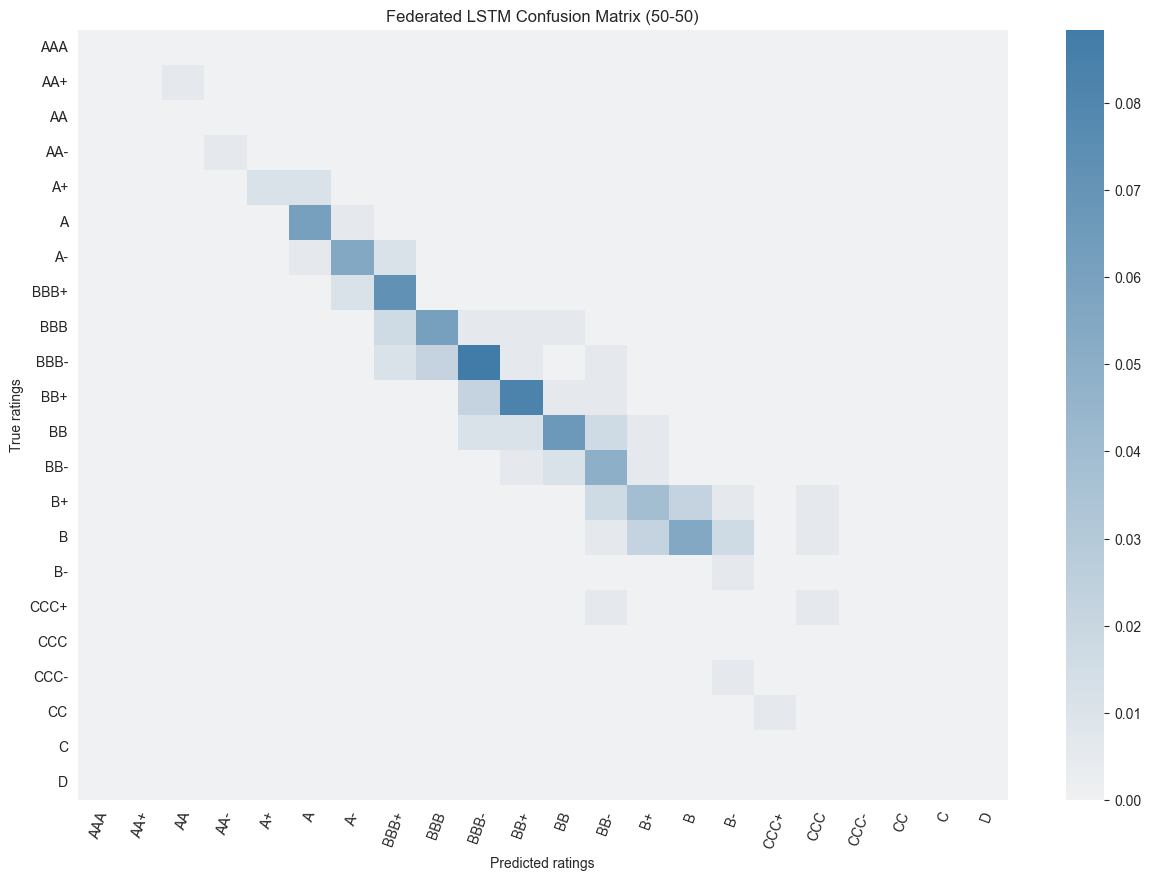

In [137]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 08:38:48,971 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 08:38:59,435	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 08:39:06,401 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1216347342.0, 'object_store_memory': 608173670.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 08:39:06,404 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 08:39:06,405 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 08:39:13,348 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 08:39:13,350 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 08:42:16,397 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 08:42:16,398 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 08:42:16,399 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 08:45:55,475 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:45:55,561 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 08:45:55,881 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:45:55,882 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 08:50:06,132 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:50:06,201 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 08:50:06,508 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:50:06,510 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 08:53:39,209 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:53:39,290 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 08:53:39,617 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:53:39,620 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 08:56:50,996 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:56:51,058 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 08:56:51,328 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 08:56:51,330 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:00:26,842 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:00:26,906 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 09:00:27,213 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:00:27,215 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:04:06,692 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:04:06,765 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 09:04:07,061 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:04:07,062 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:07:59,437 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:07:59,539 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 09:07:59,970 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:07:59,973 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:12:10,573 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:12:10,671 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 09:12:11,084 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:12:11,086 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:15:54,805 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:15:54,873 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 09:15:55,189 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:15:55,191 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:20:03,714 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:20:03,780 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 09:20:04,113 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:20:04,115 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:23:43,579 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:23:43,666 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 09:23:44,090 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:23:44,093 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:27:22,175 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:27:22,244 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 09:27:22,519 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:27:22,520 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:31:16,314 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:31:16,385 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 09:31:16,720 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:31:16,721 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:34:48,685 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:34:48,799 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 09:34:49,227 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:34:49,230 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:38:32,051 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:38:32,114 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 09:38:32,400 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:38:32,402 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:42:34,531 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:42:34,596 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 09:42:34,944 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:42:34,945 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:46:03,888 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:46:03,946 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 09:46:04,234 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:46:04,235 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:49:43,335 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:49:43,400 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 09:49:43,702 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:49:43,704 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 09:53:29,216 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 09:53:29,284 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 09:53:29,646 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 09:53:29,648 | server.py:147 | FL finished in 4456.295393700013
INFO flwr 2023-07-06 09:53:29,653 | app.py:218 | app_fit: losses_distributed [(1, 0.6629834254143646), (2, 0.6850828729281768), (3, 0.6685082872928176), (4, 0.7292817679558011), (5, 0.7237569060773481), (6, 0.8342541436464088), (7, 0.712707182320442), (8, 0.6850828729281768), (9, 0.712707182320442), (10, 0.8011049723756906), (11, 0.8066298342541437), (12, 0.8121546961325967), (13, 0.8397790055248618), (14, 0.9613259668508287), (15, 0.861878453038674), (16, 0.9171270718232044), (17, 0.8729281767955801), (18, 0.9558011049723757), (19, 0.8839779005524862), (20, 0.9116022099447514)]
INFO flwr 2023-07-06 09:53:29,656 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 09:53:29,658 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 09:53:29,658 | app.py:221 | app_fit: 

0.9116022099447514
0.002067125192618483
0.9504157495720225
0.9518716577540107


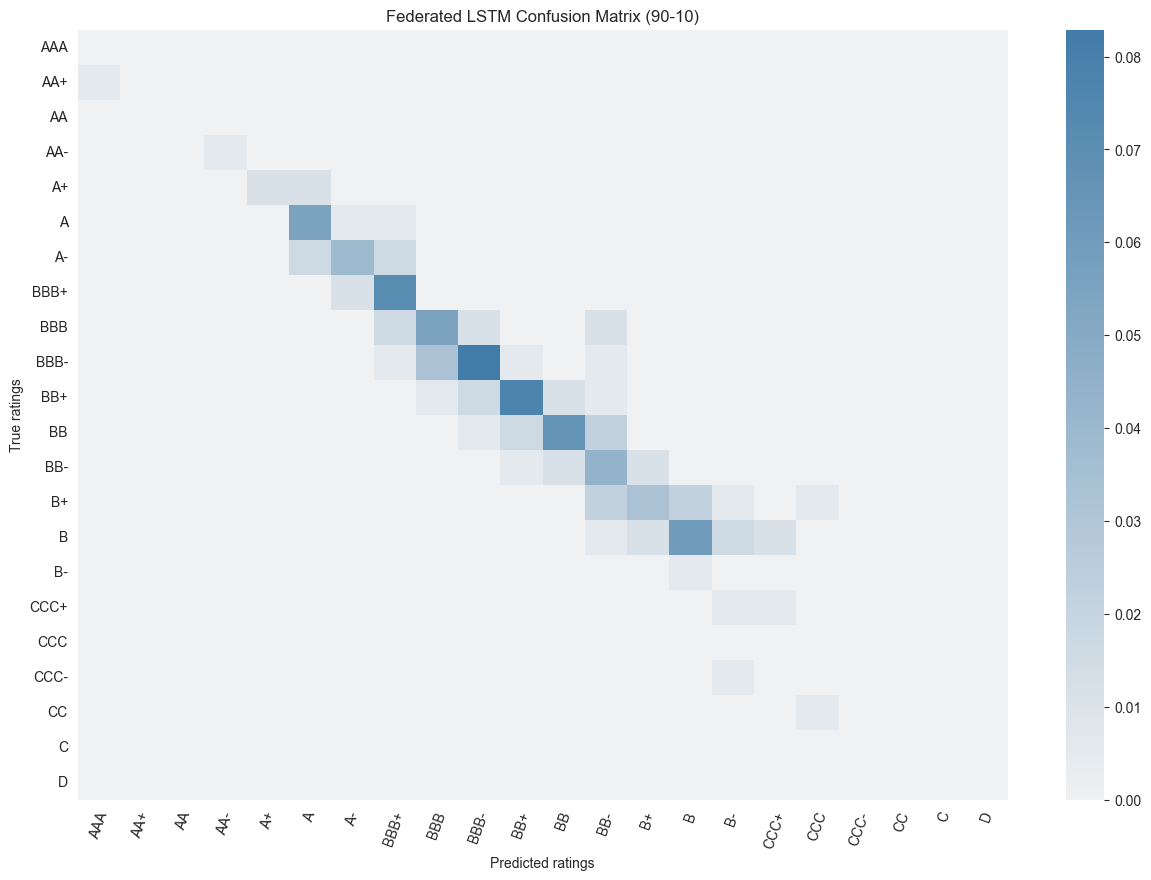

In [138]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 10:07:00,104 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 10:07:23,211	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 10:07:37,161 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 993782171.0, 'object_store_memory': 496891084.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 10:07:37,164 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 10:07:37,167 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 10:07:50,792 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 10:07:50,795 | server.py:88 | Evaluating initial parameters


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 10:10:40,363 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 10:10:40,366 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 10:10:40,368 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:13:14,416 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:13:14,512 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 10:13:14,828 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:13:14,829 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:15:18,662 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:15:18,788 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 10:15:19,278 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:15:19,281 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:17:53,958 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:17:54,031 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 10:17:54,365 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:17:54,367 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:19:52,659 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:19:52,750 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 10:19:53,033 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:19:53,068 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:21:29,789 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:21:29,894 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 10:21:30,245 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:21:30,247 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:23:38,322 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:23:38,414 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 10:23:38,721 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:23:38,723 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:25:30,682 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:25:30,777 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 10:25:31,110 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:25:31,113 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:27:28,943 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:27:29,009 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 10:27:29,350 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:27:29,352 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:28:57,196 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:28:57,261 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 10:28:57,530 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:28:57,532 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:30:57,980 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:30:58,037 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 10:30:58,283 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:30:58,284 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:32:26,088 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:32:26,161 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 10:32:26,473 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:32:26,474 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:34:12,063 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:34:12,125 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 10:34:12,403 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:34:12,406 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:35:34,781 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:35:34,844 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 10:35:35,151 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:35:35,153 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:37:19,227 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:37:19,283 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 10:37:19,572 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:37:19,608 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:38:46,776 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:38:46,857 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 10:38:47,080 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:38:47,081 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:39:55,386 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:39:55,453 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 10:39:55,747 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:39:55,748 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:42:31,143 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:42:31,209 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 10:42:31,596 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:42:31,599 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:44:28,771 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:44:28,871 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 10:44:29,158 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:44:29,159 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 10:46:14,840 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 10:46:14,914 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 10:46:15,298 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 10:46:15,301 | server.py:147 | FL finished in 2304.500454800087
INFO flwr 2023-07-06 10:46:15,305 | app.py:218 | app_fit: losses_distributed [(1, 0.7955801104972375), (2, 0.6353591160220995), (3, 0.7016574585635359), (4, 0.6408839779005525), (5, 0.6408839779005525), (6, 0.6353591160220995), (7, 0.6740331491712708), (8, 0.6629834254143646), (9, 0.6685082872928176), (10, 0.6685082872928176), (11, 0.7624309392265194), (12, 0.7900552486187845), (13, 0.8342541436464088), (14, 0.7237569060773481), (15, 0.6961325966850829), (16, 0.8453038674033149), (17, 0.7569060773480663), (18, 0.7845303867403315), (19, 0.8784530386740331), (20, 0.8176795580110497)]
INFO flwr 2023-07-06 10:46:15,307 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 10:46:15,308 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 10:46:15,309 | app.py:221 | app_fi

0.8176795580110497
0.001854148657621427
0.961054047444363
0.962962962962963


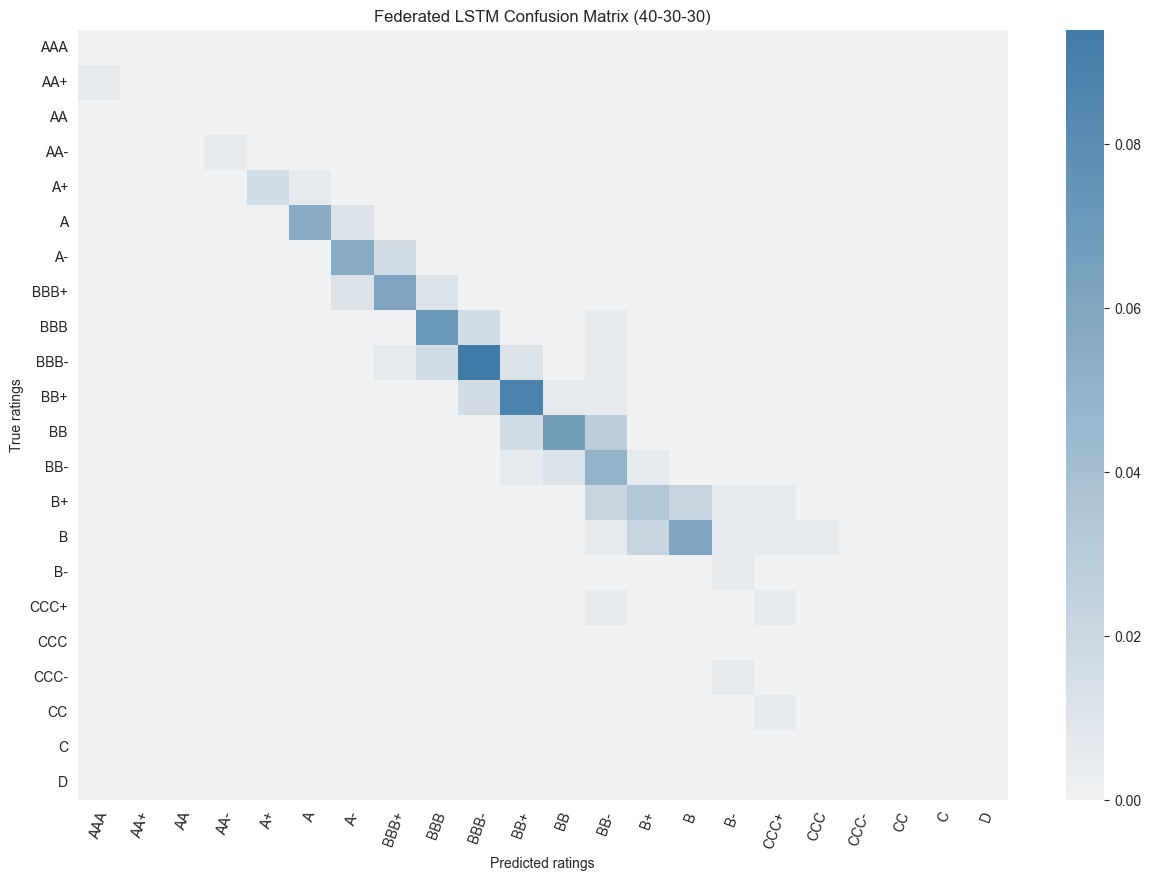

In [139]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 11:54:41,830 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 11:54:53,842	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 11:55:01,547 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1429863630.0, 'object_store_memory': 714931814.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 11:55:01,549 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 11:55:01,550 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 11:55:07,932 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 11:55:07,933 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 11:57:26,177 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 11:57:26,178 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 11:57:26,179 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 11:57:47,291 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 11:57:47,372 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 11:57:47,578 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 11:57:47,580 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 11:59:49,134 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 11:59:49,213 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 11:59:49,422 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 11:59:49,424 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:01:59,921 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:01:59,969 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 12:02:00,184 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:02:00,185 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:02:21,327 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:02:21,418 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 12:02:21,655 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:02:21,656 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:04:24,842 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:04:24,952 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 12:04:25,166 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:04:25,167 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:06:34,791 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:06:34,840 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 12:06:35,083 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:06:35,084 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:06:56,918 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:06:57,001 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 12:06:57,201 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:06:57,202 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:09:04,537 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:09:04,588 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 12:09:04,840 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:09:04,841 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:09:27,468 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:09:27,515 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 12:09:27,711 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:09:27,712 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:11:35,964 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:11:36,018 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 12:11:36,550 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:11:36,552 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:13:46,055 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:13:46,105 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 12:13:46,340 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:13:46,342 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:16:31,354 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:16:31,403 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 12:16:31,613 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:16:31,614 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:18:51,134 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:18:51,186 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 12:18:51,424 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:18:51,425 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:21:08,343 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:21:08,419 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 12:21:08,717 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:21:08,719 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:21:31,509 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:21:31,555 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 12:21:31,767 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:21:31,769 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:21:53,184 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:21:53,270 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 12:21:53,495 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:21:53,496 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:22:15,539 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:22:15,591 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 12:22:15,813 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:22:15,814 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:22:39,435 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:22:39,482 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 12:22:39,697 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:22:39,699 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-06 12:24:44,028 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:24:44,071 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 12:24:44,287 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 12:24:44,289 | server.py:147 | FL finished in 1776.353097999934
INFO flwr 2023-07-06 12:24:44,292 | app.py:218 | app_fit: losses_distributed [(1, 0.5966850828729282), (2, 0.7845303867403315), (3, 0.6464088397790055), (4, 0.6243093922651933), (5, 0.7458563535911602), (6, 0.7182320441988951), (7, 0.6629834254143646), (8, 0.6850828729281768), (9, 0.6906077348066298), (10, 0.7900552486187845), (11, 0.7071823204419889), (12, 0.6795580110497238), (13, 0.6740331491712708), (14, 0.9005524861878453), (15, 0.8729281767955801), (16, 0.8011049723756906), (17, 0.8674033149171271), (18, 0.8729281767955801), (19, 0.861878453038674), (20, 0.8950276243093923)]
INFO flwr 2023-07-06 12:24:44,293 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 12:24:44,294 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 12:24:44,295 | app.py:221 | app_fit

0.8950276243093923
0.0020295410982072385
0.961054047444363
0.962962962962963


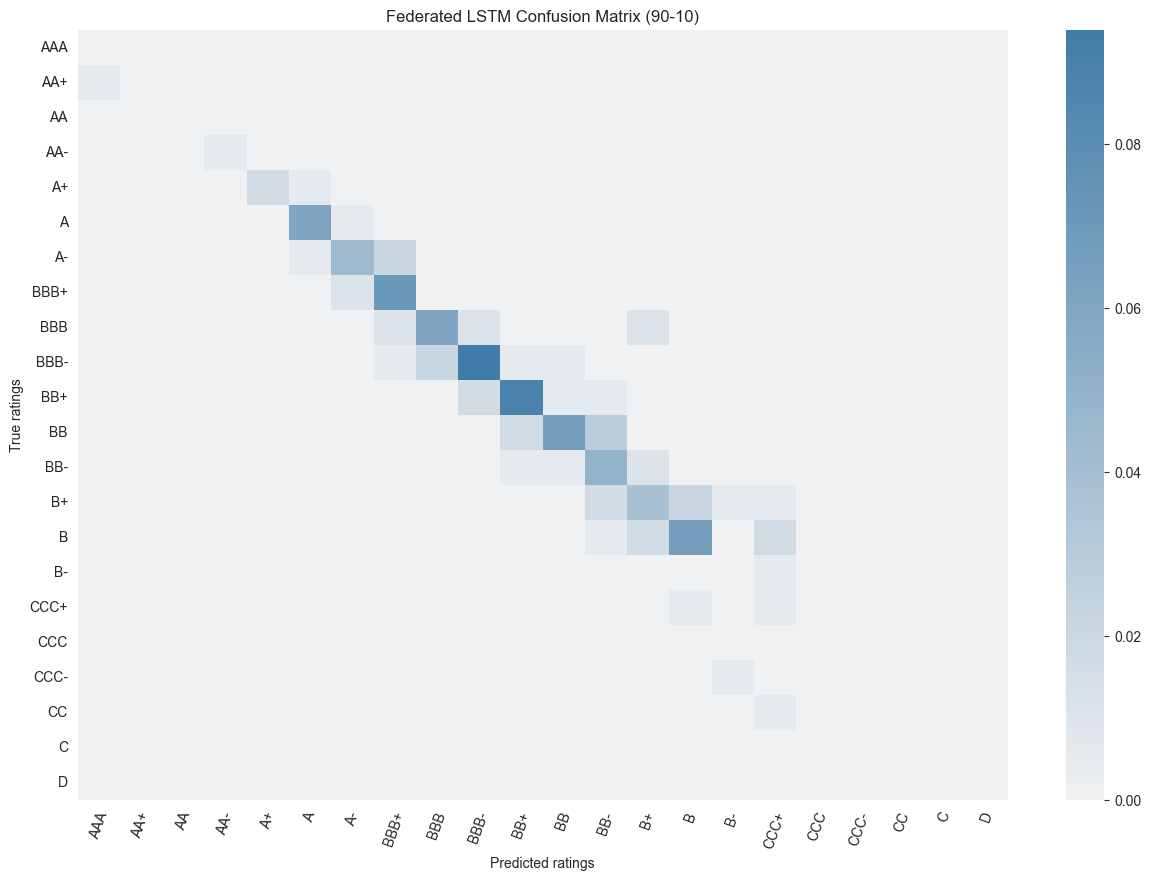

In [140]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 12:27:47,482 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 12:27:56,172	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 12:28:00,215 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1662969447.0, 'object_store_memory': 831484723.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 12:28:00,217 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 12:28:00,218 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 12:28:03,069 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 12:28:03,070 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 12:28:48,311 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 12:28:48,313 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 12:28:48,313 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:29:29,981 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:29:30,066 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 12:29:30,305 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:29:30,306 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:30:13,032 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:30:13,121 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 12:30:13,379 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:30:13,381 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:30:55,557 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:30:55,633 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 12:30:55,882 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:30:55,884 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:31:38,564 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:31:38,656 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 12:31:38,903 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:31:38,904 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:32:21,688 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:32:21,784 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 12:32:22,040 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:32:22,042 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:33:05,327 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:33:05,411 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 12:33:05,603 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:33:05,604 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:33:47,530 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:33:47,578 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 12:33:47,771 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:33:47,772 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:34:32,694 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:34:32,743 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 12:34:33,017 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:34:33,018 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:35:25,719 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:35:25,814 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 12:35:26,122 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:35:26,124 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:36:21,566 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:36:21,614 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 12:36:21,863 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:36:21,864 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:37:04,622 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:37:04,676 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 12:37:04,904 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:37:04,906 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:37:48,063 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:37:48,149 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 12:37:48,383 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:37:48,385 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:38:31,419 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:38:31,462 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 12:38:31,695 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:38:31,696 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:39:14,300 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:39:14,350 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 12:39:14,568 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:39:14,569 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:40:00,259 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:40:00,323 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 12:40:00,651 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:40:00,653 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:40:43,259 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:40:43,314 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 12:40:43,558 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:40:43,560 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:41:25,673 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:41:25,732 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 12:41:25,940 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:41:25,941 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:42:08,709 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:42:08,775 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 12:42:09,060 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:42:09,062 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 12:42:55,478 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 12:42:55,571 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 12:42:55,872 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 12:42:55,873 | server.py:147 | FL finished in 892.8018475000281
INFO flwr 2023-07-06 12:42:55,876 | app.py:218 | app_fit: losses_distributed [(1, 1.0276243093922652), (2, 0.7458563535911602), (3, 0.7900552486187845), (4, 0.8950276243093923), (5, 0.712707182320442), (6, 0.7624309392265194), (7, 0.6464088397790055), (8, 0.6353591160220995), (9, 0.6629834254143646), (10, 0.7182320441988951), (11, 0.7292817679558011), (12, 0.6574585635359116), (13, 0.8011049723756906), (14, 0.9116022099447514), (15, 0.8011049723756906), (16, 0.8287292817679558), (17, 0.7016574585635359), (18, 0.8232044198895028), (19, 0.7679558011049724), (20, 0.7348066298342542)]
INFO flwr 2023-07-06 12:42:55,877 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 12:42:55,879 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 12:42:55,880 | app.py:221 | app_fit

0.7348066298342542
0.0016662281855652017
0.9614820249449744
0.9625668449197862


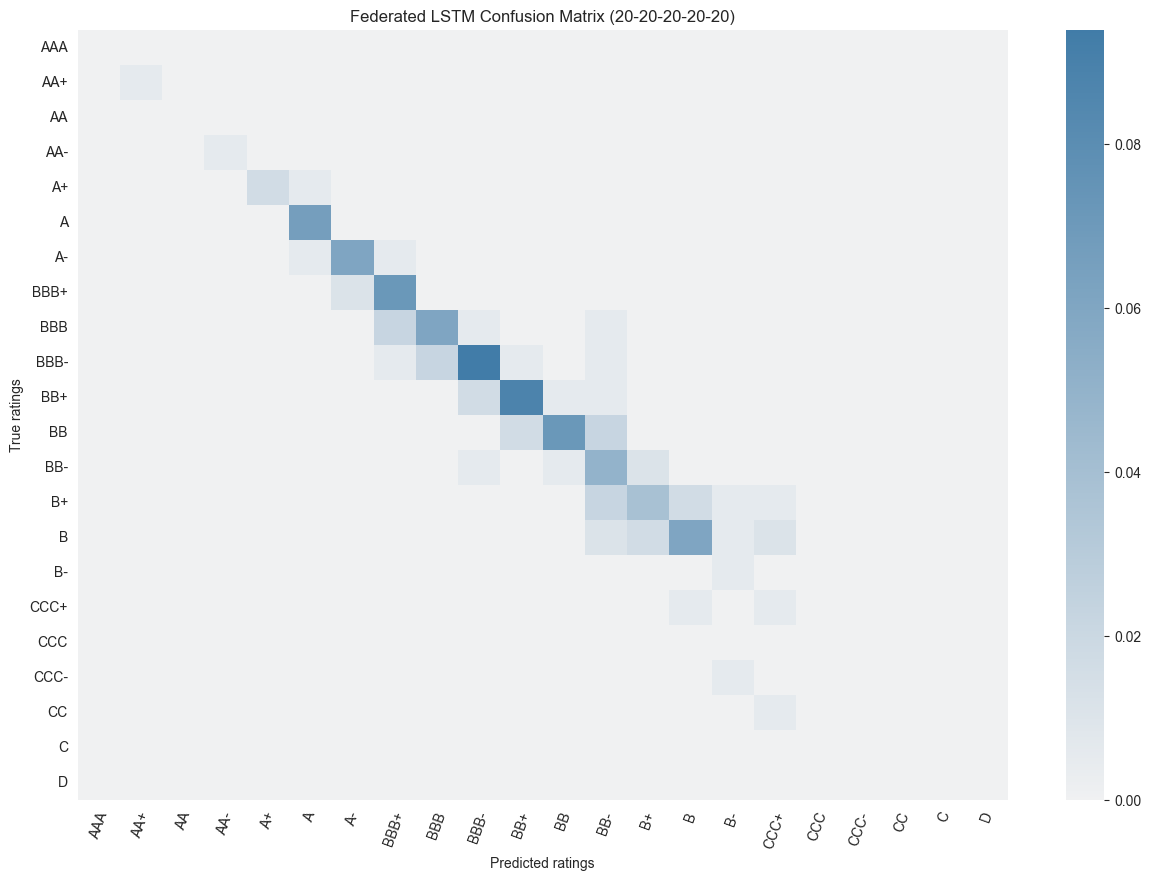

In [141]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 13:11:14,506 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 13:11:33,520	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 13:11:44,119 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1750086452.0, 'object_store_memory': 875043225.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 13:11:44,122 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 13:11:44,123 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 13:11:51,227 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 13:11:51,228 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 13:14:32,925 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 13:14:32,926 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 13:14:32,927 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:15:02,471 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:15:02,585 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 13:15:02,891 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:15:02,892 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:17:19,205 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:17:19,302 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 13:17:19,607 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:17:19,608 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:19:25,678 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:19:25,745 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 13:19:26,012 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:19:26,014 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:19:51,954 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:19:52,049 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 13:19:52,279 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:19:52,280 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:20:19,461 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:20:19,554 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 13:20:19,846 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:20:19,848 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:22:25,788 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:22:25,865 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 13:22:26,172 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:22:26,174 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:25:26,475 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:25:26,547 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 13:25:26,852 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:25:26,854 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:25:54,773 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:25:54,831 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 13:25:55,086 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:25:55,088 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:26:21,205 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:26:21,275 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 13:26:21,549 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:26:21,550 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:28:15,806 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:28:15,874 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 13:28:16,283 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:28:16,285 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:30:08,516 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:30:08,583 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 13:30:08,849 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:30:08,850 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:30:35,343 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:30:35,391 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 13:30:35,635 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:30:35,636 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:31:00,351 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:31:00,407 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 13:31:00,667 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:31:00,668 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:32:50,621 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:32:50,673 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 13:32:50,921 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:32:50,922 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:34:42,305 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:34:42,352 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 13:34:42,566 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:34:42,567 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:36:30,625 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:36:30,686 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 13:36:30,948 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:36:30,950 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:36:52,978 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:36:53,031 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 13:36:53,272 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:36:53,273 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:37:17,371 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:37:17,423 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 13:37:17,700 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:37:17,702 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-06 13:37:39,611 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 13:37:39,661 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 13:37:39,900 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 13:37:39,901 | server.py:147 | FL finished in 1548.6715840999968
INFO flwr 2023-07-06 13:37:39,905 | app.py:218 | app_fit: losses_distributed [(1, 0.712707182320442), (2, 0.7292817679558011), (3, 0.7182320441988951), (4, 0.6408839779005525), (5, 0.6740331491712708), (6, 0.7569060773480663), (7, 0.7624309392265194), (8, 0.8397790055248618), (9, 0.6187845303867403), (10, 0.7900552486187845), (11, 0.7734806629834254), (12, 0.9171270718232044), (13, 0.7569060773480663), (14, 0.7513812154696132), (15, 0.8287292817679558), (16, 0.9060773480662984), (17, 0.9116022099447514), (18, 0.7734806629834254), (19, 0.7845303867403315), (20, 0.861878453038674)]
INFO flwr 2023-07-06 13:37:39,906 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 13:37:39,907 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 13:37:39,908 | app.py:221 | app_fit

0.861878453038674
0.0019543729093847483
0.9721203228173148
0.9735449735449735


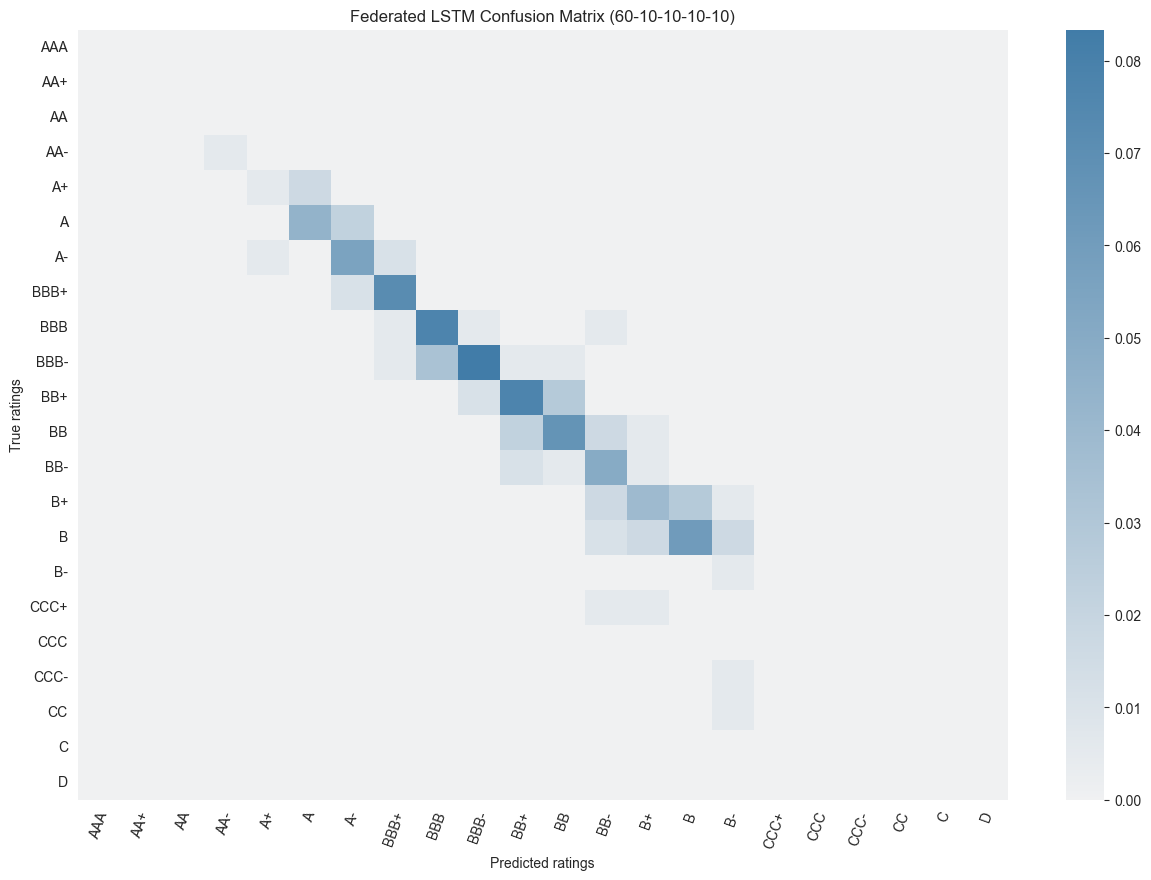

In [142]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

In [ ]:
# Visualise loss convergence 32 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 56.794729542302356), (2, 56.79750346740638), (3, 4.633841886269071), (4, 0.9958391123439667), (5, 1.0540915395284327), (6, 0.9958391123439667), (7, 0.9750346740638003), (8, 0.9292649098474342), (9, 0.9209431345353676), (10, 0.9292649098474342), (11, 0.8626907073509015), (12, 0.8723994452149791), (13, 0.8488210818307905), (14, 0.8654646324549237), (15, 0.8918169209431346), (16, 0.8307905686546463), (17, 0.8987517337031901), (18, 0.8335644937586685), (19, 0.8432732316227461), (20, 0.8169209431345353)]
, [(1, 33.49237170596394), (2, 33.49237170596394), (3, 33.48543689320388), (4, 1.3398058252427185), (5, 0.941747572815534), (6, 0.9112343966712899), (7, 0.8654646324549237), (8, 0.8945908460471568), (9, 0.8613037447988904), (10, 0.8668515950069348), (11, 0.9070735090152566), (12, 0.9098474341192788), (13, 0.9778085991678225), (14, 0.871012482662968), (15, 0.9375866851595007), (16, 0.9902912621359223), (17, 0.970873786407767), (18, 0.8793342579750347), (19, 0.9306518723994452), (20, 0.9306518723994452)]
, [(1, 51.20249653259362), (2, 33.55617198335645), (3, 1.0513176144244105), (4, 1.0332871012482663), (5, 1.0208044382801664), (6, 1.0180305131761442), (7, 1.030513176144244), (8, 1.044382801664355), (9, 0.957004160887656), (10, 0.9764216366158114), (11, 0.9653259361997226), (12, 0.9736477115117892), (13, 0.9320388349514563), (14, 0.9514563106796117), (15, 0.9583911234396671), (16, 0.9042995839112344), (17, 0.8959778085991679), (18, 0.871012482662968), (19, 0.8959778085991679), (20, 0.9375866851595007)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 1.2857142857142858), (6, 1.3203883495145632), (7, 1.029126213592233), (8, 0.9112343966712899), (9, 1.3730929264909848), (10, 0.9015256588072122), (11, 1.2316227461858529), (12, 1.3231622746185854), (13, 0.8432732316227461), (14, 0.8502080443828016), (15, 0.8571428571428571), (16, 1.1525658807212205), (17, 0.855755894590846), (18, 0.8391123439667129), (19, 0.8987517337031901), (20, 1.1525658807212205)]
, [(1, 88.40499306518724), (2, 72.66990291262135), (3, 71.43966712898752), (4, 71.40499306518724), (5, 17.780859916782248), (6, 17.79889042995839), (7, 17.77253814147018), (8, 17.66990291262136), (9, 17.764216366158113), (10, 1.0624133148404993), (11, 1.015256588072122), (12, 0.9805825242718447), (13, 1.0041608876560333), (14, 1.1872399445214978), (15, 1.0679611650485437), (16, 1.0610263522884882), (17, 1.0818307905686546), (18, 1.072122052704577), (19, 1.1775312066574202), (20, 1.0332871012482663)]
, [(1, 72.43273231622746), (2, 71.69070735090152), (3, 71.41331484049931), (4, 71.39251040221914), (5, 71.39251040221914), (6, 10.47018030513176), (7, 1.2122052704576975), (8, 1.1664355062413314), (9, 1.0083217753120666), (10, 1.08876560332871), (11, 1.1081830790568654), (12, 1.1733703190013869), (13, 1.0416088765603329), (14, 1.0776699029126213), (15, 0.9750346740638003), (16, 1.0027739251040222), (17, 1.0638002773925104), (18, 0.9833564493758669), (19, 1.072122052704577), (20, 1.1872399445214978)]]
, start=0, title='Num epoch: 32')

#### 64 Epoch

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 13:51:39,948 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 13:51:59,672	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 13:52:04,840 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1610190030.0, 'object_store_memory': 805095014.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 13:52:04,842 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 13:52:04,843 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 13:52:10,510 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 13:52:10,512 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 13:56:37,833 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 13:56:37,834 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 13:56:37,834 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:00:21,413 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:00:21,465 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 14:00:21,687 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:00:21,689 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:04:14,540 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:04:14,594 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 14:04:14,818 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:04:14,820 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:07:58,545 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:07:58,595 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 14:07:58,810 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:07:58,811 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:11:32,968 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:11:33,022 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 14:11:33,247 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:11:33,248 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:15:52,254 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:15:52,313 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 14:15:52,509 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:15:52,510 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:19:36,644 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:19:36,705 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 14:19:36,930 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:19:36,932 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:23:19,494 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:23:19,553 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 14:23:19,748 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:23:19,749 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:27:10,381 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:27:10,436 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 14:27:10,673 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:27:10,675 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:31:19,933 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:31:19,982 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 14:31:20,182 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:31:20,183 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:34:59,059 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:34:59,115 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 14:34:59,375 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:34:59,377 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:38:39,250 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:38:39,294 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 14:38:39,510 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:38:39,512 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:42:14,674 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:42:14,737 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 14:42:14,936 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:42:14,937 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:45:48,479 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:45:48,529 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 14:45:48,784 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:45:48,785 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:49:30,974 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:49:31,021 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 14:49:31,203 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:49:31,205 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:53:15,680 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:53:15,737 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 14:53:15,971 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:53:15,972 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 14:56:47,805 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:56:47,849 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 14:56:48,063 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 14:56:48,063 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 15:00:32,982 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:00:33,030 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 15:00:33,238 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:00:33,239 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 15:04:16,828 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:04:16,905 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 15:04:17,224 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:04:17,225 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 15:07:43,168 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:07:43,218 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 15:07:43,416 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 15:07:43,417 | server.py:147 | FL finished in 4532.9021722000325
INFO flwr 2023-07-06 15:07:43,419 | app.py:218 | app_fit: losses_distributed [(1, 0.7071823204419889), (2, 0.6519337016574586), (3, 0.6243093922651933), (4, 0.6243093922651933), (5, 0.8176795580110497), (6, 0.8066298342541437), (7, 0.8397790055248618), (8, 0.7679558011049724), (9, 0.8729281767955801), (10, 0.9613259668508287), (11, 0.9558011049723757), (12, 0.9171270718232044), (13, 0.9060773480662984), (14, 0.8729281767955801), (15, 0.8839779005524862), (16, 0.856353591160221), (17, 0.8729281767955801), (18, 0.9668508287292817), (19, 0.8895027624309392), (20, 0.8287292817679558)]
INFO flwr 2023-07-06 15:07:43,419 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 15:07:43,420 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 15:07:43,421 | app.py:221 | app_fi

0.8287292817679558
0.0018792047205622576
0.9668011738811445
0.9680851063829787


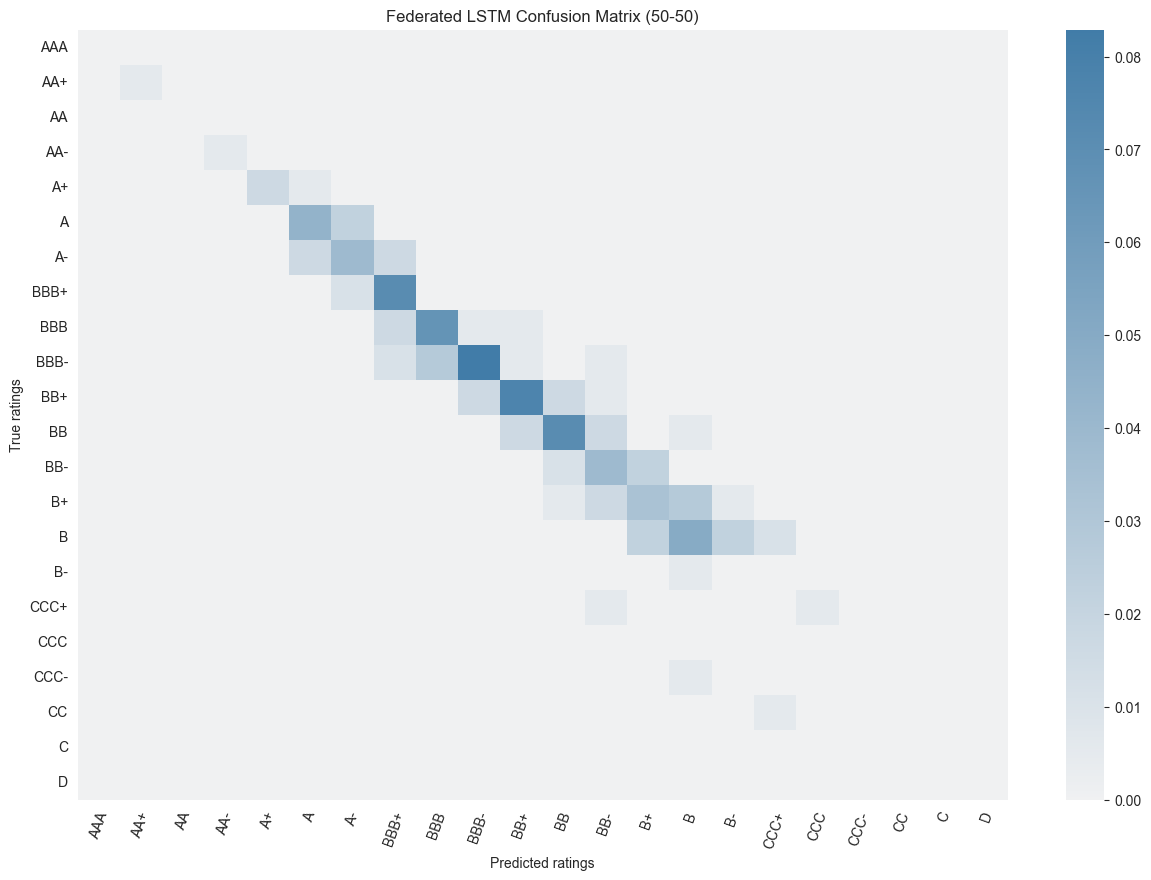

In [143]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-06 15:42:33,707 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-06 15:42:49,479	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-06 15:42:55,621 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 818282496.0, 'object_store_memory': 409141248.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-06 15:42:55,623 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-06 15:42:55,624 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-06 15:43:01,671 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-06 15:43:01,672 | server.py:88 | Evaluating initial parameters


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-06 15:47:59,614 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-06 15:47:59,615 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-06 15:47:59,616 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 15:52:54,141 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:52:54,214 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-06 15:52:54,476 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:52:54,477 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 15:57:53,717 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:57:53,777 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-06 15:57:53,992 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-06 15:57:53,993 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:02:52,034 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:02:52,080 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-06 16:02:52,286 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:02:52,287 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:07:50,306 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:07:50,366 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-06 16:07:50,570 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:07:50,571 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:13:00,908 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:13:00,952 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-06 16:13:01,153 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:13:01,154 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:18:01,960 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:18:02,014 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-06 16:18:02,211 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:18:02,212 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:23:04,755 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:23:04,807 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-06 16:23:04,989 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:23:04,990 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:28:11,485 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:28:11,536 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-06 16:28:11,760 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:28:11,761 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:33:10,072 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:33:10,118 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-06 16:33:10,323 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:33:10,325 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:38:28,396 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:38:28,449 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-06 16:38:28,676 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:38:28,677 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:43:51,642 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:43:51,689 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-06 16:43:51,914 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:43:51,916 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:49:07,655 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:49:07,709 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-06 16:49:07,920 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:49:07,922 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:54:22,967 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:54:23,025 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-06 16:54:23,249 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:54:23,251 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 16:59:25,599 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:59:25,654 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-06 16:59:25,880 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-06 16:59:25,881 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 17:04:31,181 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:04:31,225 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-06 17:04:31,427 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:04:31,428 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 17:09:21,177 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:09:21,222 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-06 17:09:21,452 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:09:21,453 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 17:14:09,082 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:14:09,134 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-06 17:14:09,339 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:14:09,341 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 17:18:52,105 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:18:52,152 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-06 17:18:52,370 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:18:52,371 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-07-06 17:23:45,342 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-06 17:23:45,401 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-06 17:23:45,616 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-06 17:23:45,617 | server.py:147 | FL finished in 6043.943093699985
INFO flwr 2023-07-06 17:23:45,621 | app.py:218 | app_fit: losses_distributed [(1, 0.5911602209944752), (2, 0.6961325966850829), (3, 0.8011049723756906), (4, 0.7845303867403315), (5, 0.8674033149171271), (6, 1.011049723756906), (7, 0.8950276243093923), (8, 0.9723756906077348), (9, 0.8453038674033149), (10, 0.8453038674033149), (11, 0.8397790055248618), (12, 0.8784530386740331), (13, 0.7900552486187845), (14, 0.856353591160221), (15, 0.8895027624309392), (16, 0.8232044198895028), (17, 0.9558011049723757), (18, 0.856353591160221), (19, 0.994475138121547), (20, 0.9226519337016574)]
INFO flwr 2023-07-06 17:23:45,623 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-06 17:23:45,624 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-06 17:23:45,625 | app.py:221 | app_fit: l

0.9226519337016574
0.0020921812555593144
0.9504157495720225
0.9518716577540107


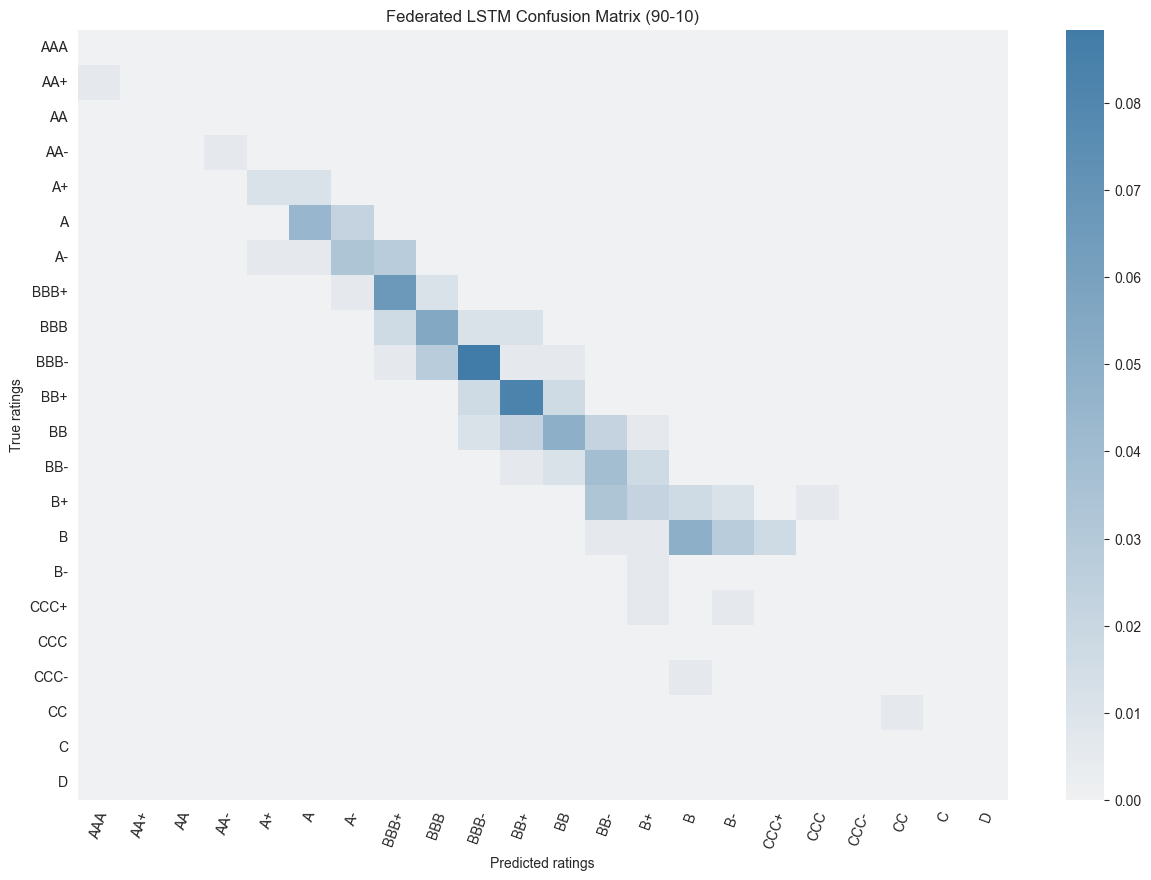

In [144]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-07 12:24:27,822 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-07 12:24:45,080	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-07 12:24:49,518 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1595631207.0, 'object_store_memory': 797815603.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-07 12:24:49,519 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-07 12:24:49,520 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-07 12:24:54,281 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-07 12:24:54,282 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-07 12:27:33,944 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-07 12:27:33,946 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-07 12:27:33,946 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:29:33,189 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:29:33,289 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-07 12:29:33,539 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:29:33,541 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:32:00,152 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:32:00,197 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-07 12:32:00,410 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:32:00,411 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:34:07,421 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:34:07,472 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-07 12:34:07,672 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:34:07,673 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:36:43,360 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:36:43,417 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-07 12:36:43,627 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:36:43,628 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:39:26,175 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:39:26,232 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-07 12:39:26,553 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:39:26,555 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:42:20,389 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:42:20,447 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-07 12:42:20,664 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:42:20,665 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:45:02,280 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:45:02,328 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-07 12:45:02,554 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:45:02,555 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:47:36,241 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:47:36,292 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-07 12:47:36,502 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:47:36,526 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:50:21,470 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:50:21,514 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-07 12:50:21,758 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:50:21,759 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:52:53,097 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:52:53,144 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-07 12:52:53,392 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:52:53,393 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:55:20,383 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:55:20,431 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-07 12:55:20,632 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:55:20,633 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 12:57:52,831 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:57:52,885 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-07 12:57:53,130 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-07 12:57:53,164 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 13:01:20,462 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:01:20,525 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-07 13:01:20,787 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:01:20,789 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 13:04:31,990 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:04:32,045 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-07 13:04:32,298 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:04:32,299 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 13:07:03,377 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:07:03,488 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-07 13:07:03,831 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:07:03,833 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 13:09:52,637 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:09:52,694 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-07 13:09:52,909 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:09:52,911 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 13:12:21,126 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:12:21,169 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-07 13:12:21,358 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:12:21,360 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 13:14:29,933 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:14:30,017 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-07 13:14:30,292 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:14:30,294 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 13:17:05,306 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-07 13:17:05,387 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-07 13:17:05,653 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-07 13:17:05,654 | server.py:147 | FL finished in 3131.3701213999884
INFO flwr 2023-07-07 13:17:05,693 | app.py:218 | app_fit: losses_distributed [(1, 0.7513812154696132), (2, 0.8895027624309392), (3, 0.7182320441988951), (4, 0.6740331491712708), (5, 0.8176795580110497), (6, 0.856353591160221), (7, 0.9116022099447514), (8, 0.9337016574585635), (9, 1.0055248618784531), (10, 0.9558011049723757), (11, 0.9447513812154696), (12, 0.861878453038674), (13, 0.9668508287292817), (14, 0.9834254143646409), (15, 1.0607734806629834), (16, 0.861878453038674), (17, 0.850828729281768), (18, 1.0497237569060773), (19, 0.9668508287292817), (20, 1.0055248618784531)]
INFO flwr 2023-07-07 13:17:05,694 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-07 13:17:05,694 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-07 13:17:05,695 | app.py:221 | app_fit: 

1.0055248618784531
0.0022801017276155395
0.9504157495720225
0.9518716577540107


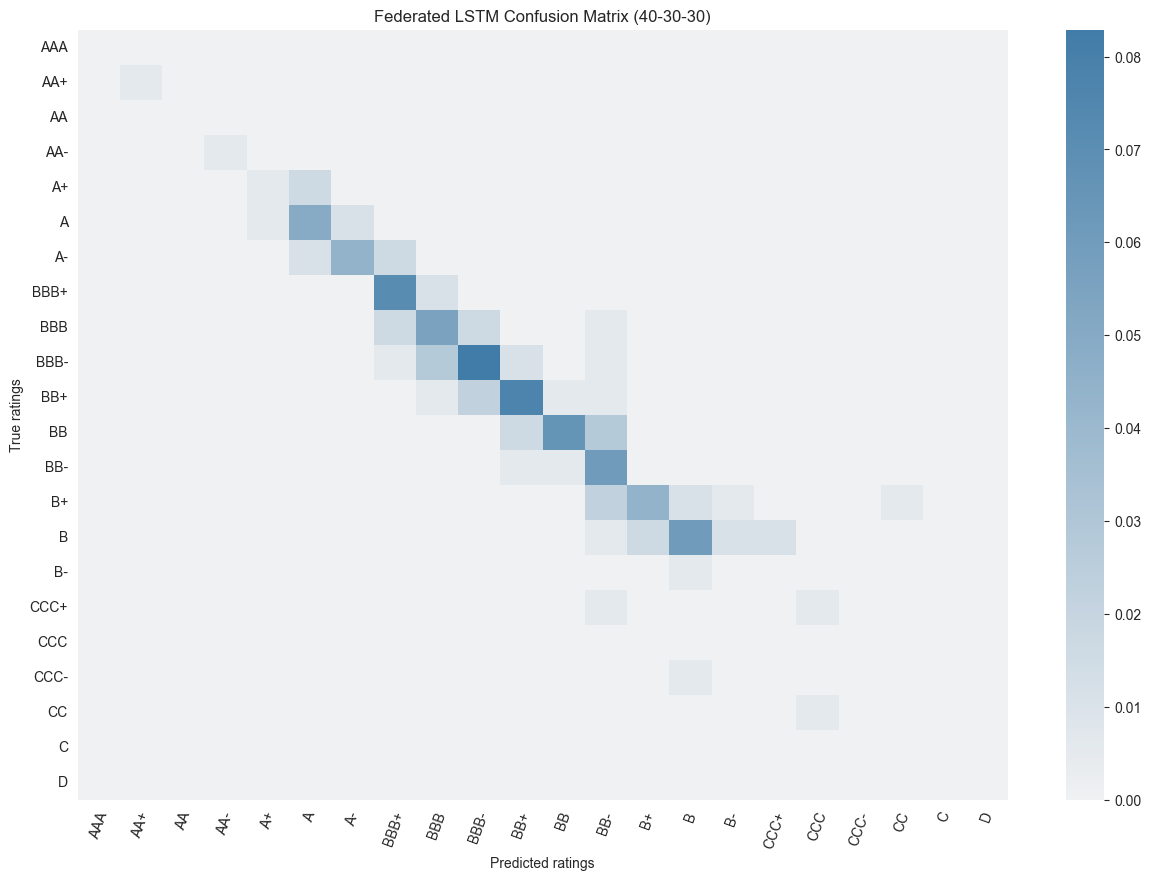

In [145]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-07 13:55:45,531 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-07 13:56:02,710	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-07 13:56:09,707 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1738184295.0, 'object_store_memory': 869092147.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-07 13:56:09,709 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-07 13:56:09,711 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-07 13:56:17,482 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-07 13:56:17,484 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-07 13:57:20,301 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-07 13:57:20,303 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-07 13:57:20,304 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:02:53,422 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:02:53,528 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-07 14:02:53,970 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:02:53,973 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:11:08,878 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:11:08,982 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-07 14:11:09,351 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:11:09,353 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:12:21,356 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:12:21,487 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-07 14:12:21,871 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:12:21,874 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:13:34,106 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:13:34,230 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-07 14:13:34,644 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:13:34,647 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:14:46,875 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:14:46,971 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-07 14:14:47,340 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:14:47,343 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:15:59,876 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:16:00,015 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-07 14:16:00,430 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:16:00,432 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:17:17,976 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:17:18,131 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-07 14:17:18,548 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:17:18,550 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:22:45,792 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:22:45,840 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-07 14:22:46,068 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:22:46,069 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:26:50,800 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:26:50,851 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-07 14:26:51,070 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:26:51,071 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:27:33,115 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:27:33,169 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-07 14:27:33,439 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:27:33,441 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:32:39,372 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:32:39,427 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-07 14:32:39,683 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:32:39,684 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:37:39,292 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:37:39,357 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-07 14:37:39,614 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:37:39,615 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:38:32,183 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:38:32,269 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-07 14:38:32,585 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:38:32,585 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:39:32,634 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:39:32,719 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-07 14:39:33,025 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:39:33,026 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:44:36,004 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:44:36,056 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-07 14:44:36,298 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:44:36,299 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:49:32,472 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:49:32,539 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-07 14:49:32,824 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:49:32,826 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:54:38,372 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:54:38,422 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-07 14:54:38,633 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:54:38,634 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 14:59:44,290 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:59:44,342 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-07 14:59:44,577 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-07 14:59:44,578 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-07-07 15:04:52,185 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-07 15:04:52,276 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-07 15:04:52,657 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-07 15:04:52,659 | server.py:147 | FL finished in 4115.173098700005
INFO flwr 2023-07-07 15:04:52,664 | app.py:218 | app_fit: losses_distributed [(1, 1.0828729281767955), (2, 0.6574585635359116), (3, 0.6022099447513812), (4, 0.7900552486187845), (5, 0.9337016574585635), (6, 0.9668508287292817), (7, 0.9834254143646409), (8, 1.0552486187845305), (9, 0.7790055248618785), (10, 0.7458563535911602), (11, 0.9060773480662984), (12, 0.7679558011049724), (13, 0.8287292817679558), (14, 1.0), (15, 0.9502762430939227), (16, 0.8011049723756906), (17, 0.8784530386740331), (18, 0.9558011049723757), (19, 0.9558011049723757), (20, 1.0055248618784531)]
INFO flwr 2023-07-07 15:04:52,666 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-07 15:04:52,668 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-07 15:04:52,670 | app.py:221 | app_fit: losses_centr

1.0055248618784531
0.0022801017276155395
0.9663731963805332
0.968421052631579


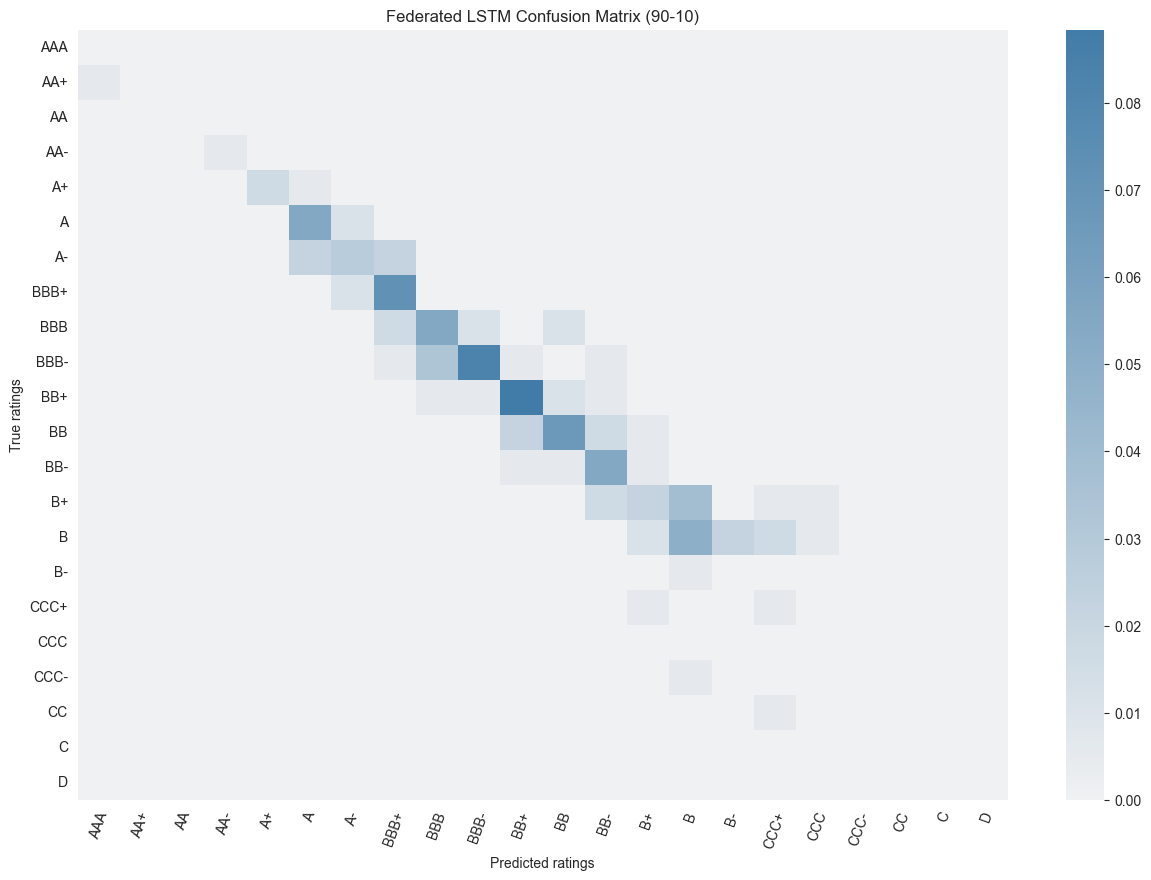

In [146]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

D:\FD\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-07-07 16:49:41,360 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-07-07 16:49:52,486	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-07-07 16:49:58,284 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 1426978407.0, 'object_store_memory': 713489203.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-07 16:49:58,286 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-07 16:49:58,288 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-07 16:50:05,083 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-07 16:50:05,084 | server.py:88 | Evaluating initial parameters

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-07-07 16:51:45,541 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-07 16:51:45,543 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-07 16:51:45,543 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 16:53:17,280 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:53:17,324 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-07-07 16:53:17,526 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:53:17,527 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 16:54:43,373 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:54:43,417 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-07-07 16:54:43,611 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:54:43,612 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 16:56:23,553 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:56:23,607 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-07-07 16:56:23,796 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:56:23,798 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 16:57:44,331 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:57:44,408 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-07-07 16:57:44,617 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:57:44,618 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 16:59:05,724 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:59:05,774 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-07-07 16:59:05,986 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-07-07 16:59:05,987 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:00:29,666 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:00:29,751 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-07-07 17:00:29,961 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:00:29,962 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:01:52,476 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:01:52,525 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-07-07 17:01:52,755 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:01:52,757 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:03:42,210 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:03:42,252 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-07-07 17:03:42,488 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:03:42,489 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:05:23,330 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:05:23,411 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-07-07 17:05:23,732 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:05:23,734 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:07:10,746 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:07:10,800 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-07-07 17:07:11,118 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:07:11,119 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:08:51,510 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:08:51,571 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-07-07 17:08:51,859 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:08:51,861 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:10:34,444 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:10:34,532 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-07-07 17:10:34,839 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:10:34,841 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:12:36,052 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:12:36,188 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-07-07 17:12:36,607 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:12:36,610 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:15:08,771 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:15:08,876 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-07-07 17:15:09,360 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:15:09,363 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:17:42,143 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:17:42,289 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-07-07 17:17:42,656 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:17:42,659 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:20:14,967 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:20:15,047 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-07-07 17:20:15,425 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:20:15,427 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:22:51,729 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:22:51,816 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-07-07 17:22:52,235 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:22:52,238 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:25:29,562 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:25:29,663 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-07-07 17:25:30,132 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:25:30,134 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-07-07 17:27:57,501 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-07-07 17:27:57,586 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-07-07 17:27:58,003 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-07-07 17:27:58,005 | server.py:147 | FL finished in 2272.9189326999476
INFO flwr 2023-07-07 17:27:58,011 | app.py:218 | app_fit: losses_distributed [(1, 0.8784530386740331), (2, 0.8895027624309392), (3, 0.9779005524861878), (4, 0.8176795580110497), (5, 0.8453038674033149), (6, 0.8066298342541437), (7, 0.7624309392265194), (8, 0.8453038674033149), (9, 0.7513812154696132), (10, 0.8121546961325967), (11, 0.861878453038674), (12, 0.9171270718232044), (13, 0.9337016574585635), (14, 0.9281767955801105), (15, 0.9613259668508287), (16, 0.7679558011049724), (17, 0.8176795580110497), (18, 0.861878453038674), (19, 0.8066298342541437), (20, 0.7900552486187845)]
INFO flwr 2023-07-07 17:27:58,013 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-07 17:27:58,015 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-07 17:27:58,016 | app.py:221 | app_fit

0.7900552486187845
0.0017915085002693522
0.9725483003179262
0.9732620320855615


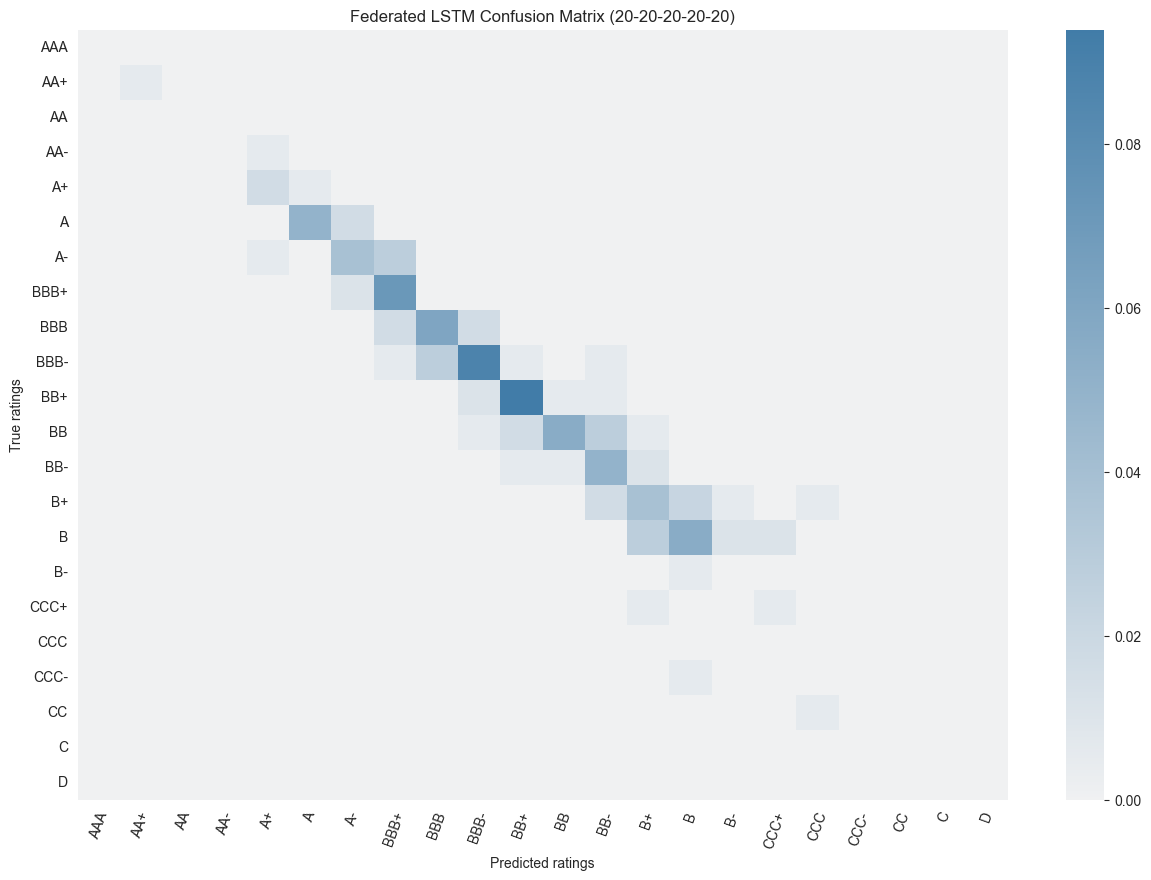

In [148]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

In [ ]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

In [ ]:
# Visualise loss convergence 64 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 71.39667128987517), (2, 1.0360610263522885), (3, 1.0471567267683772), (4, 0.9667128987517337), (5, 0.9029126213592233), (6, 0.9916782246879334), (7, 0.9431345353675451), (8, 0.9680998613037448), (9, 0.9778085991678225), (10, 0.9625520110957004), (11, 0.9667128987517337), (12, 0.9875173370319001), (13, 0.9597780859916782), (14, 0.955617198335645), (15, 0.9958391123439667), (16, 1.0027739251040222), (17, 0.957004160887656), (18, 0.970873786407767), (19, 0.9528432732316228), (20, 0.9542302357836339)]
, [(1, 56.793342579750345), (2, 1.013869625520111), (3, 0.941747572815534), (4, 0.9680998613037448), (5, 0.8959778085991679), (6, 0.8793342579750347), (7, 0.912621359223301), (8, 0.9015256588072122), (9, 0.8807212205270458), (10, 0.9070735090152566), (11, 0.9375866851595007), (12, 0.9140083217753121), (13, 0.9140083217753121), (14, 0.9167822468793343), (15, 0.9112343966712899), (16, 0.9209431345353676), (17, 0.9403606102635229), (18, 0.9459084604715673), (19, 1.1137309292649098), (20, 1.0790568654646324)]
, [(1, 44.19278779472954), (2, 44.20804438280167), (3, 44.19140083217753), (4, 1.0499306518723994), (5, 1.0457697642163661), (6, 1.1345353675450762), (7, 1.0832177531206657), (8, 1.0846047156726768), (9, 1.0610263522884882), (10, 1.0846047156726768), (11, 1.246879334257975), (12, 1.2233009708737863), (13, 1.0651872399445215), (14, 1.1248266296809986), (15, 1.1553398058252426), (16, 1.073509015256588), (17, 1.058252427184466), (18, 1.116504854368932), (19, 1.116504854368932), (20, 1.0846047156726768)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 56.793342579750345), (5, 8.134535367545077), (6, 0.8529819694868238), (7, 1.3592233009708738), (8, 1.3689320388349515), (9, 1.3800277392510403), (10, 1.3689320388349515), (11, 0.8377253814147018), (12, 1.1484049930651872), (13, 0.926490984743412), (14, 0.8751733703190014), (15, 0.8793342579750347), (16, 1.0610263522884882), (17, 0.8654646324549237), (18, 0.8904299583911235), (19, 0.9375866851595007), (20, 1.0485436893203883)]
, [(1, 17.889042995839112), (2, 17.77253814147018), (3, 17.72122052704577), (4, 1.0540915395284327), (5, 1.1511789181692094), (6, 1.1262135922330097), (7, 1.1234396671289875), (8, 1.0402219140083218), (9, 1.1067961165048543), (10, 1.0249653259361997), (11, 1.3509015256588073), (12, 1.2787794729542303), (13, 1.4105409153952844), (14, 1.319001386962552), (15, 1.3245492371705965), (16, 1.1248266296809986), (17, 1.246879334257975), (18, 1.0832177531206657), (19, 1.1359223300970873), (20, 1.2524271844660195)]
, [(1, 106.5991678224688), (2, 106.59084604715673), (3, 5.439667128987518), (4, 1.6310679611650485), (5, 1.1248266296809986), (6, 1.5977808599167822), (7, 1.7323162274618584), (8, 1.2302357836338418), (9, 1.0624133148404993), (10, 1.3398058252427185), (11, 1.1789181692094313), (12, 1.1262135922330097), (13, 1.1927877947295422), (14, 1.2066574202496532), (15, 1.2066574202496532), (16, 1.6740638002773924), (17, 1.4965325936199723), (18, 1.1276005547850207), (19, 1.3925104022191401), (20, 1.418862690707351)]]
, start=0, title='Num epoch: 64')

#### 16 Epoch

In [ ]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

In [ ]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

In [ ]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

In [ ]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

In [ ]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

In [ ]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

In [ ]:
# Visualise loss convergence 16 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 3.938973647711512), (2, 2.2441054091539527), (3, 2.0776699029126213), (4, 2.056865464632455), (5, 1.9361997226074896), (6, 2.0083217753120666), (7, 1.0388349514563107), (8, 0.9639389736477115), (9, 0.9237170596393898), (10, 0.9306518723994452), (11, 0.883495145631068), (12, 0.8821081830790569), (13, 0.9791955617198336), (14, 0.8543689320388349), (15, 0.8779472954230236), (16, 0.8377253814147018), (17, 0.8571428571428571), (18, 0.8751733703190014), (19, 0.8807212205270458), (20, 0.840499306518724), (21, 0.871012482662968), (22, 0.8502080443828016), (23, 0.8599167822468793), (24, 0.8668515950069348), (25, 0.8529819694868238), (26, 0.8737864077669902), (27, 0.8626907073509015), (28, 0.8515950069348127), (29, 0.840499306518724), (30, 0.8515950069348127), (31, 0.8807212205270458), (32, 0.8654646324549237), (33, 0.8779472954230236), (34, 0.8654646324549237), (35, 0.8682385575589459), (36, 0.8613037447988904), (37, 0.8932038834951457), (38, 0.8793342579750347), (39, 0.8918169209431346), (40, 0.9084604715672677)]
, [(1, 8.402219140083218), (2, 8.162274618585299), (3, 8.10124826629681), (4, 8.090152565880722), (5, 1.2829403606102636), (6, 1.2441054091539527), (7, 1.0901525658807212), (8, 1.0485436893203883), (9, 0.912621359223301), (10, 0.8890429958391124), (11, 0.8723994452149791), (12, 0.8599167822468793), (13, 0.8391123439667129), (14, 0.8613037447988904), (15, 0.8307905686546463), (16, 0.8654646324549237), (17, 0.8626907073509015), (18, 0.8294036061026352), (19, 0.8307905686546463), (20, 0.8502080443828016), (21, 0.8529819694868238), (22, 0.8571428571428571), (23, 0.8446601941747572), (24, 0.8474341192787794), (25, 0.9029126213592233), (26, 0.883495145631068), (27, 0.8751733703190014), (28, 0.9292649098474342), (29, 0.8890429958391124), (30, 0.9112343966712899), (31, 0.9042995839112344), (32, 0.9403606102635229), (33, 0.9486823855755895), (34, 0.9001386962552012), (35, 0.8751733703190014), (36, 0.897364771151179), (37, 0.8862690707350902), (38, 0.9597780859916782), (39, 0.8626907073509015), (40, 0.8307905686546463)]
, [(1, 57.30513176144244), (2, 56.81553398058252), (3, 56.80443828016644), (4, 56.793342579750345), (5, 56.793342579750345), (6, 56.80443828016644), (7, 12.486823855755894), (8, 1.4729542302357836), (9, 1.3092926490984744), (10, 1.4160887656033287), (11, 1.3495145631067962), (12, 1.3592233009708738), (13, 1.246879334257975), (14, 1.0776699029126213), (15, 1.0180305131761442), (16, 0.9791955617198336), (17, 0.9805825242718447), (18, 0.9667128987517337), (19, 0.9902912621359223), (20, 0.9916782246879334), (21, 0.9514563106796117), (22, 0.9791955617198336), (23, 0.9694868238557559), (24, 0.9403606102635229), (25, 0.9583911234396671), (26, 0.9889042995839112), (27, 0.9930651872399445), (28, 0.9805825242718447), (29, 0.970873786407767), (30, 0.941747572815534), (31, 0.9653259361997226), (32, 0.9694868238557559), (33, 0.9667128987517337), (34, 0.955617198335645), (35, 0.941747572815534), (36, 0.9791955617198336), (37, 1.0083217753120666), (38, 0.9500693481276006), (39, 0.9361997226074896), (40, 1.0055478502080444)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 90.57420249653259), (5, 88.72676837725382), (6, 88.29403606102635), (7, 71.500693481276), (8, 71.40499306518724), (9, 71.39112343966713), (10, 1.0055478502080444), (11, 0.9292649098474342), (12, 0.9251040221914009), (13, 0.8821081830790569), (14, 0.8460471567267683), (15, 0.8474341192787794), (16, 0.8474341192787794), (17, 0.8599167822468793), (18, 0.871012482662968), (19, 0.9611650485436893), (20, 0.8613037447988904), (21, 0.9181692094313454), (22, 0.957004160887656), (23, 0.840499306518724), (24, 1.0457697642163661), (25, 0.8280166435506241), (26, 1.015256588072122), (27, 0.7988904299583911), (28, 0.9694868238557559), (29, 1.1206657420249653), (30, 0.811373092926491), (31, 0.8252427184466019), (32, 0.7988904299583911), (33, 1.0748959778085991), (34, 0.8196948682385575), (35, 0.8432732316227461), (36, 1.0235783633841886), (37, 0.840499306518724), (38, 1.0471567267683772), (39, 0.8737864077669902), (40, 0.9902912621359223)]
, [(1, 88.64909847434119), (2, 88.33287101248267), (3, 88.23300970873787), (4, 88.00693481276005), (5, 74.03606102635229), (6, 71.49791955617198), (7, 71.41470180305132), (8, 71.41470180305132), (9, 71.40221914008322), (10, 9.765603328710124), (11, 2.2149791955617197), (12, 2.0374479889042996), (13, 1.9472954230235784), (14, 1.9223300970873787), (15, 1.9251040221914009), (16, 1.9209431345353676), (17, 1.0416088765603329), (18, 1.1054091539528432), (19, 1.072122052704577), (20, 1.0984743411927878), (21, 1.0374479889042996), (22, 0.9986130374479889), (23, 1.0374479889042996), (24, 1.0416088765603329), (25, 0.9833564493758669), (26, 0.9791955617198336), (27, 0.984743411927878), (28, 1.0263522884882108), (29, 0.9389736477115118), (30, 1.1206657420249653), (31, 1.0693481276005548), (32, 0.8945908460471568), (33, 0.9653259361997226), (34, 0.9875173370319001), (35, 1.1664355062413314), (36, 0.9459084604715673), (37, 1.0110957004160888), (38, 0.9015256588072122), (39, 0.9542302357836339), (40, 1.0180305131761442)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 9.084604715672677), (7, 5.325936199722608), (8, 5.235783633841886), (9, 1.058252427184466), (10, 1.3092926490984744), (11, 1.0527045769764216), (12, 1.2357836338418862), (13, 1.0194174757281553), (14, 1.0374479889042996), (15, 1.0027739251040222), (16, 1.0346740638002774), (17, 1.015256588072122), (18, 1.2246879334257974), (19, 1.027739251040222), (20, 1.001386962552011), (21, 1.0402219140083218), (22, 1.0624133148404993), (23, 1.072122052704577), (24, 1.0332871012482663), (25, 1.056865464632455), (26, 1.0346740638002774), (27, 1.0651872399445215), (28, 1.0610263522884882), (29, 1.2496532593619971), (30, 1.3578363384188628), (31, 1.116504854368932), (32, 1.1345353675450762), (33, 1.1262135922330097), (34, 1.2718446601941749), (35, 1.073509015256588), (36, 1.30374479889043), (37, 1.145631067961165), (38, 1.361997226074896), (39, 1.1955617198335644), (40, 1.19001386962552)]]
, start=0, title='Num epoch: 16')

#### 8 Epoch

In [ ]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

In [ ]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

In [ ]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

In [ ]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

In [ ]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

In [ ]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

In [ ]:
# Visualise loss convergence 8 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 88.8876560332871), (2, 57.22607489597781), (3, 33.61442441054091), (4, 33.47572815533981), (5, 33.50901525658807), (6, 33.499306518724), (7, 33.49514563106796), (8, 33.486823855755894), (9, 33.486823855755894), (10, 33.488210818307905), (11, 33.48127600554785), (12, 33.48266296809986), (13, 33.479889042995836), (14, 1.030513176144244), (15, 0.9583911234396671), (16, 0.9278779472954231), (17, 0.9348127600554785), (18, 0.9736477115117892), (19, 0.9001386962552012), (20, 0.8959778085991679), (21, 0.9237170596393898), (22, 0.869625520110957), (23, 0.9167822468793343), (24, 0.8682385575589459), (25, 0.8529819694868238), (26, 0.8460471567267683), (27, 0.8515950069348127), (28, 0.8335644937586685), (29, 0.8654646324549237), (30, 0.8640776699029126), (31, 0.8474341192787794), (32, 0.8793342579750347), (33, 0.8363384188626907), (34, 0.812760055478502), (35, 0.812760055478502), (36, 0.8099861303744799), (37, 0.8335644937586685), (38, 0.826629680998613), (39, 0.8030513176144244), (40, 0.826629680998613)]
, [(1, 75.22052704576977), (2, 71.54646324549238), (3, 71.4507628294036), (4, 71.42995839112344), (5, 57.205270457697644), (6, 2.0527045769764216), (7, 1.1692094313453536), (8, 1.0970873786407767), (9, 0.986130374479889), (10, 1.0027739251040222), (11, 1.072122052704577), (12, 0.9694868238557559), (13, 0.9251040221914009), (14, 0.9403606102635229), (15, 0.9667128987517337), (16, 0.8932038834951457), (17, 0.9112343966712899), (18, 0.8640776699029126), (19, 0.8932038834951457), (20, 0.9334257975034674), (21, 0.8585298196948682), (22, 0.8668515950069348), (23, 0.9070735090152566), (24, 0.8821081830790569), (25, 0.8599167822468793), (26, 0.8391123439667129), (27, 0.9001386962552012), (28, 0.8307905686546463), (29, 0.855755894590846), (30, 0.855755894590846), (31, 0.840499306518724), (32, 0.8196948682385575), (33, 0.8529819694868238), (34, 0.8377253814147018), (35, 0.9348127600554785), (36, 0.8280166435506241), (37, 0.8196948682385575), (38, 0.8238557558945908), (39, 0.8543689320388349), (40, 0.9167822468793343)]
, [(1, 73.29680998613037), (2, 71.76560332871013), (3, 71.55201109570042), (4, 71.47434119278779), (5, 71.41886269070736), (6, 71.39667128987517), (7, 71.40776699029126), (8, 71.40776699029126), (9, 71.39251040221914), (10, 71.39251040221914), (11, 21.81137309292649), (12, 12.421636615811373), (13, 12.228848821081831), (14, 2.041608876560333), (15, 1.1858529819694867), (16, 1.188626907073509), (17, 1.0319001386962552), (18, 1.0818307905686546), (19, 1.0485436893203883), (20, 1.0208044382801664), (21, 1.0346740638002774), (22, 0.9944521497919556), (23, 0.9514563106796117), (24, 0.9514563106796117), (25, 0.9819694868238558), (26, 0.9667128987517337), (27, 0.9722607489597781), (28, 0.9334257975034674), (29, 0.9611650485436893), (30, 0.9348127600554785), (31, 0.9445214979195562), (32, 0.9736477115117892), (33, 0.9514563106796117), (34, 0.9528432732316228), (35, 0.955617198335645), (36, 0.9875173370319001), (37, 0.9195561719833565), (38, 0.9209431345353676), (39, 0.9029126213592233), (40, 0.9209431345353676)]
, [(1, 127.17337031900139), (2, 89.5131761442441), (3, 88.1997226074896), (4, 8.76005547850208), (5, 8.44382801664355), (6, 5.356449375866852), (7, 5.223300970873787), (8, 1.0804438280166435), (9, 1.0166435506241331), (10, 1.0610263522884882), (11, 1.073509015256588), (12, 0.9625520110957004), (13, 0.9140083217753121), (14, 0.970873786407767), (15, 0.9486823855755895), (16, 0.9001386962552012), (17, 0.9597780859916782), (18, 0.9223300970873787), (19, 1.0527045769764216), (20, 0.9167822468793343), (21, 0.9237170596393898), (22, 0.9167822468793343), (23, 0.8529819694868238), (24, 0.9084604715672677), (25, 1.001386962552011), (26, 0.9902912621359223), (27, 0.883495145631068), (28, 0.9764216366158114), (29, 0.9001386962552012), (30, 0.8474341192787794), (31, 1.0624133148404993), (32, 0.9472954230235784), (33, 1.0083217753120666), (34, 0.8599167822468793), (35, 0.8183079056865464), (36, 0.8155339805825242), (37, 0.8252427184466019), (38, 0.8196948682385575), (39, 0.8155339805825242), (40, 0.811373092926491)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 127.17337031900139), (7, 127.17337031900139), (8, 127.17337031900139), (9, 127.17337031900139), (10, 127.17337031900139), (11, 127.17337031900139), (12, 127.17337031900139), (13, 127.17337031900139), (14, 127.17337031900139), (15, 127.17337031900139), (16, 127.17337031900139), (17, 127.17337031900139), (18, 8.635228848821082), (19, 5.737864077669903), (20, 5.490984743411928), (21, 5.406380027739251), (22, 1.3398058252427185), (23, 1.2760055478502081), (24, 1.0693481276005548), (25, 1.1137309292649098), (26, 1.0748959778085991), (27, 1.056865464632455), (28, 1.0790568654646324), (29, 0.9167822468793343), (30, 0.9791955617198336), (31, 0.9819694868238558), (32, 0.9750346740638003), (33, 0.8918169209431346), (34, 0.9348127600554785), (35, 0.9001386962552012), (36, 0.8723994452149791), (37, 0.883495145631068), (38, 0.9680998613037448), (39, 0.9070735090152566), (40, 0.9653259361997226)]
, [(1, 89.47572815533981), (2, 88.19556171983356), (3, 62.64771151178918), (4, 56.92787794729542), (5, 56.85991678224688), (6, 56.85436893203884), (7, 56.858529819694866), (8, 56.87101248266297), (9, 56.79195561719833), (10, 56.793342579750345), (11, 56.79195561719833), (12, 56.793342579750345), (13, 17.15395284327323), (14, 12.475728155339805), (15, 1.5256588072122053), (16, 1.4507628294036061), (17, 1.4008321775312067), (18, 1.4882108183079057), (19, 1.2260748959778085), (20, 1.2815533980582525), (21, 1.130374479889043), (22, 1.1373092926490984), (23, 1.0208044382801664), (24, 1.0124826629680999), (25, 0.9875173370319001), (26, 1.0124826629680999), (27, 1.0221914008321775), (28, 1.0069348127600555), (29, 1.0638002773925104), (30, 1.0263522884882108), (31, 1.0194174757281553), (32, 0.9958391123439667), (33, 1.0041608876560333), (34, 1.0235783633841886), (35, 0.9902912621359223), (36, 0.955617198335645), (37, 0.9722607489597781), (38, 0.9348127600554785), (39, 0.9875173370319001), (40, 0.9750346740638003)]]
, start=0, title='Num epoch: 8')

#### 4 Epoch

In [ ]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

In [ ]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

In [ ]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

In [ ]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

In [ ]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

In [ ]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

In [ ]:
# Visualise loss convergence 4 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 127.17337031900139), (2, 127.17337031900139), (3, 25.187239944521497), (4, 25.03606102635229), (5, 24.9500693481276), (6, 24.8626907073509), (7, 24.814147018030514), (8, 24.78640776699029), (9, 24.776699029126213), (10, 24.787794729542302), (11, 24.76976421636616), (12, 24.742024965325935), (13, 24.730929264909847), (14, 1.1484049930651872), (15, 1.1816920943134535), (16, 1.1109570041608876), (17, 1.029126213592233), (18, 1.0069348127600555), (19, 1.176144244105409), (20, 1.0984743411927878), (21, 1.0180305131761442), (22, 1.029126213592233), (23, 0.9694868238557559), (24, 0.9833564493758669), (25, 0.9486823855755895), (26, 0.970873786407767), (27, 0.9334257975034674), (28, 0.9653259361997226), (29, 0.9722607489597781), (30, 0.9694868238557559), (31, 0.9348127600554785), (32, 0.9472954230235784), (33, 0.8918169209431346), (34, 0.9001386962552012), (35, 0.9056865464632455), (36, 0.9056865464632455), (37, 0.8862690707350902), (38, 0.9930651872399445), (39, 0.912621359223301), (40, 0.9070735090152566), (41, 0.8848821081830791), (42, 0.9084604715672677), (43, 0.8723994452149791), (44, 0.869625520110957), (45, 0.8654646324549237), (46, 0.8821081830790569), (47, 0.9098474341192788), (48, 0.8613037447988904), (49, 0.8529819694868238), (50, 0.8807212205270458), (51, 0.8779472954230236), (52, 0.986130374479889), (53, 0.841886269070735), (54, 0.8585298196948682), (55, 0.8377253814147018), (56, 0.8751733703190014), (57, 0.8585298196948682), (58, 0.8682385575589459), (59, 0.8377253814147018), (60, 0.8543689320388349), (61, 0.8613037447988904), (62, 0.8238557558945908), (63, 0.8585298196948682), (64, 0.8529819694868238), (65, 0.8515950069348127), (66, 0.841886269070735), (67, 0.8391123439667129), (68, 0.8363384188626907), (69, 0.8183079056865464), (70, 0.8737864077669902), (71, 0.8640776699029126), (72, 1.0069348127600555), (73, 0.8460471567267683), (74, 0.8252427184466019), (75, 0.8155339805825242), (76, 0.8349514563106796), (77, 0.8543689320388349), (78, 0.8391123439667129), (79, 0.8252427184466019), (80, 0.8252427184466019)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 74.23578363384189), (7, 2.289875173370319), (8, 1.3356449375866852), (9, 1.1567267683772537), (10, 1.1484049930651872), (11, 1.0221914008321775), (12, 1.0221914008321775), (13, 1.0527045769764216), (14, 0.9889042995839112), (15, 1.0707350901525658), (16, 1.0249653259361997), (17, 0.984743411927878), (18, 0.9916782246879334), (19, 1.0235783633841886), (20, 1.0166435506241331), (21, 0.9958391123439667), (22, 1.0832177531206657), (23, 1.273231622746186), (24, 1.0402219140083218), (25, 0.9986130374479889), (26, 1.0208044382801664), (27, 1.08876560332871), (28, 0.9389736477115118), (29, 1.0360610263522885), (30, 0.9944521497919556), (31, 0.9389736477115118), (32, 0.941747572815534), (33, 0.9445214979195562), (34, 0.9195561719833565), (35, 0.8599167822468793), (36, 0.8959778085991679), (37, 0.9778085991678225), (38, 0.9348127600554785), (39, 0.9348127600554785), (40, 0.9431345353675451), (41, 0.8737864077669902), (42, 0.9625520110957004), (43, 0.9098474341192788), (44, 0.8585298196948682), (45, 0.9195561719833565), (46, 1.0651872399445215), (47, 0.8571428571428571), (48, 0.8349514563106796), (49, 0.8613037447988904), (50, 0.8599167822468793), (51, 0.8613037447988904), (52, 0.8876560332871013), (53, 0.8363384188626907), (54, 0.9930651872399445), (55, 0.840499306518724), (56, 0.8432732316227461), (57, 0.8987517337031901), (58, 0.9001386962552012), (59, 0.8515950069348127), (60, 0.8432732316227461), (61, 0.9597780859916782), (62, 0.840499306518724), (63, 0.883495145631068), (64, 0.8640776699029126), (65, 0.8599167822468793), (66, 0.8474341192787794), (67, 0.8807212205270458), (68, 0.9833564493758669), (69, 0.8474341192787794), (70, 0.8793342579750347), (71, 0.8321775312066574), (72, 0.8474341192787794), (73, 0.8793342579750347), (74, 0.8945908460471568), (75, 1.0651872399445215), (76, 0.9348127600554785), (77, 0.855755894590846), (78, 0.840499306518724), (79, 0.883495145631068), (80, 0.8626907073509015)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 107.500693481276), (4, 106.8987517337032), (5, 106.85298196948682), (6, 106.73647711511789), (7, 106.68238557558946), (8, 106.6629680998613), (9, 106.63384188626907), (10, 106.64355062413316), (11, 106.61719833564494), (12, 106.61026352288488), (13, 106.61026352288488), (14, 106.62690707350902), (15, 106.63384188626907), (16, 106.62690707350902), (17, 106.58668515950069), (18, 106.59361997226075), (19, 106.59361997226075), (20, 106.59361997226075), (21, 106.58252427184466), (22, 19.76976421636616), (23, 4.638002773925104), (24, 3.059639389736477), (25, 2.0693481276005548), (26, 1.4230235783633842), (27, 1.8765603328710125), (28, 1.0651872399445215), (29, 1.1581137309292648), (30, 1.1719833564493758), (31, 1.0194174757281553), (32, 1.0624133148404993), (33, 0.9986130374479889), (34, 0.9819694868238558), (35, 1.0194174757281553), (36, 1.0166435506241331), (37, 0.9805825242718447), (38, 0.9986130374479889), (39, 0.9653259361997226), (40, 0.9916782246879334), (41, 1.0332871012482663), (42, 0.9694868238557559), (43, 0.9805825242718447), (44, 0.9278779472954231), (45, 0.9153952843273232), (46, 0.9680998613037448), (47, 0.9403606102635229), (48, 0.9694868238557559), (49, 0.9500693481276006), (50, 0.9445214979195562), (51, 0.9611650485436893), (52, 0.9750346740638003), (53, 0.9098474341192788), (54, 0.8945908460471568), (55, 0.9153952843273232), (56, 0.9833564493758669), (57, 0.9334257975034674), (58, 0.9930651872399445), (59, 0.9237170596393898), (60, 0.9320388349514563), (61, 0.9056865464632455), (62, 0.9514563106796117), (63, 0.9167822468793343), (64, 0.9251040221914009), (65, 0.9361997226074896), (66, 0.9015256588072122), (67, 0.9181692094313454), (68, 0.9029126213592233), (69, 0.9375866851595007), (70, 0.9292649098474342), (71, 0.9403606102635229), (72, 0.9320388349514563), (73, 0.8904299583911235), (74, 0.8876560332871013), (75, 0.9348127600554785), (76, 0.9195561719833565), (77, 0.9209431345353676), (78, 0.8945908460471568), (79, 0.9195561719833565), (80, 0.8918169209431346)]
, [(1, 20.715672676837727), (2, 10.30235783633842), (3, 10.095700416088766), (4, 9.027739251040222), (5, 8.764216366158113), (6, 8.72122052704577), (7, 8.295423023578364), (8, 8.256588072122053), (9, 8.25242718446602), (10, 8.27877947295423), (11, 8.185852981969488), (12, 8.17753120665742), (13, 8.20388349514563), (14, 8.167822468793343), (15, 8.156726768377254), (16, 8.169209431345354), (17, 7.058252427184466), (18, 3.2288488210818307), (19, 3.163661581137309), (20, 1.0374479889042996), (21, 1.0263522884882108), (22, 1.0748959778085991), (23, 1.0402219140083218), (24, 1.0540915395284327), (25, 1.056865464632455), (26, 1.0943134535367545), (27, 0.9944521497919556), (28, 0.9611650485436893), (29, 1.0069348127600555), (30, 0.9667128987517337), (31, 0.9972260748959778), (32, 1.015256588072122), (33, 0.9680998613037448), (34, 0.9833564493758669), (35, 1.0665742024965326), (36, 0.9334257975034674), (37, 0.9278779472954231), (38, 0.9334257975034674), (39, 0.8779472954230236), (40, 0.926490984743412), (41, 0.9889042995839112), (42, 0.9653259361997226), (43, 0.9722607489597781), (44, 1.0846047156726768), (45, 0.9750346740638003), (46, 0.9389736477115118), (47, 0.8932038834951457), (48, 0.8959778085991679), (49, 0.8474341192787794), (50, 0.926490984743412), (51, 0.8876560332871013), (52, 0.8529819694868238), (53, 0.855755894590846), (54, 0.8959778085991679), (55, 0.8585298196948682), (56, 0.8460471567267683), (57, 0.9306518723994452), (58, 0.8363384188626907), (59, 0.9334257975034674), (60, 1.015256588072122), (61, 0.9611650485436893), (62, 0.8571428571428571), (63, 0.8391123439667129), (64, 0.871012482662968), (65, 0.8737864077669902), (66, 0.9500693481276006), (67, 0.8585298196948682), (68, 0.9042995839112344), (69, 0.8543689320388349), (70, 0.9001386962552012), (71, 0.8321775312066574), (72, 0.8751733703190014), (73, 0.8876560332871013), (74, 0.8793342579750347), (75, 0.8571428571428571), (76, 0.8058252427184466), (77, 0.8751733703190014), (78, 0.9112343966712899), (79, 0.9223300970873787), (80, 1.001386962552011)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 66.52427184466019), (5, 58.17891816920943), (6, 57.48127600554785), (7, 57.23439667128987), (8, 57.12621359223301), (9, 57.07073509015257), (10, 57.01664355062413), (11, 56.92787794729542), (12, 56.905686546463244), (13, 56.90984743411928), (14, 56.86962552011096), (15, 56.8377253814147), (16, 56.81553398058252), (17, 56.81553398058252), (18, 56.79611650485437), (19, 56.794729542302356), (20, 56.793342579750345), (21, 56.78918169209431), (22, 56.794729542302356), (23, 56.794729542302356), (24, 56.794729542302356), (25, 56.794729542302356), (26, 56.794729542302356), (27, 56.794729542302356), (28, 56.793342579750345), (29, 56.794729542302356), (30, 56.794729542302356), (31, 56.793342579750345), (32, 56.793342579750345), (33, 56.78918169209431), (34, 56.78918169209431), (35, 56.793342579750345), (36, 56.78918169209431), (37, 10.660194174757281), (38, 2.2732316227461857), (39, 1.4549237170596394), (40, 1.176144244105409), (41, 1.0929264909847434), (42, 1.0679611650485437), (43, 1.1054091539528432), (44, 1.0748959778085991), (45, 1.131761442441054), (46, 1.1664355062413314), (47, 1.1234396671289875), (48, 1.1054091539528432), (49, 1.0513176144244105), (50, 1.0097087378640777), (51, 0.9972260748959778), (52, 1.0180305131761442), (53, 1.0249653259361997), (54, 1.0332871012482663), (55, 0.9972260748959778), (56, 1.0360610263522885), (57, 0.9694868238557559), (58, 1.0208044382801664), (59, 0.9653259361997226), (60, 1.0069348127600555), (61, 0.9625520110957004), (62, 0.9986130374479889), (63, 0.9819694868238558), (64, 1.0346740638002774), (65, 0.955617198335645), (66, 1.001386962552011), (67, 0.9819694868238558), (68, 0.9930651872399445), (69, 0.9791955617198336), (70, 0.9667128987517337), (71, 0.9611650485436893), (72, 0.9389736477115118), (73, 0.957004160887656), (74, 0.9195561719833565), (75, 0.9791955617198336), (76, 0.9694868238557559), (77, 0.9722607489597781), (78, 1.001386962552011), (79, 0.9819694868238558), (80, 0.9472954230235784)]
, [(1, 127.17337031900139), (2, 109.10263522884883), (3, 106.72676837725382), (4, 106.65325936199723), (5, 106.59639389736478), (6, 106.58113730929264), (7, 106.58113730929264), (8, 106.58113730929264), (9, 106.58113730929264), (10, 106.58113730929264), (11, 106.58113730929264), (12, 106.58113730929264), (13, 106.58113730929264), (14, 106.58113730929264), (15, 106.58113730929264), (16, 106.58113730929264), (17, 106.58113730929264), (18, 70.03190013869626), (19, 3.6712898751733705), (20, 2.002773925104022), (21, 1.5561719833564494), (22, 1.2843273231622747), (23, 1.273231622746186), (24, 1.2981969486823857), (25, 1.1969486823855755), (26, 1.1400832177531206), (27, 1.087378640776699), (28, 1.188626907073509), (29, 1.1969486823855755), (30, 1.1345353675450762), (31, 1.1109570041608876), (32, 1.1095700416088765), (33, 1.1428571428571428), (34, 1.0804438280166435), (35, 1.1067961165048543), (36, 1.0610263522884882), (37, 1.0929264909847434), (38, 1.0679611650485437), (39, 1.087378640776699), (40, 1.1525658807212205), (41, 1.0638002773925104), (42, 1.289875173370319), (43, 1.1109570041608876), (44, 1.0998613037447988), (45, 1.1234396671289875), (46, 1.0527045769764216), (47, 1.085991678224688), (48, 1.10124826629681), (49, 1.1414701803051317), (50, 1.073509015256588), (51, 1.0790568654646324), (52, 1.087378640776699), (53, 1.1955617198335644), (54, 1.0624133148404993), (55, 1.1192787794729542), (56, 1.1955617198335644), (57, 1.0984743411927878), (58, 1.0957004160887656), (59, 1.0832177531206657), (60, 1.0748959778085991), (61, 1.0943134535367545), (62, 1.0748959778085991), (63, 1.058252427184466), (64, 1.0790568654646324), (65, 1.0846047156726768), (66, 1.0804438280166435), (67, 1.1109570041608876), (68, 1.042995839112344), (69, 1.072122052704577), (70, 1.0665742024965326), (71, 1.0818307905686546), (72, 1.059639389736477), (73, 1.0818307905686546), (74, 1.0984743411927878), (75, 1.1359223300970873), (76, 1.0748959778085991), (77, 1.056865464632455), (78, 1.073509015256588), (79, 1.0707350901525658), (80, 1.073509015256588)]]
, start=0, title='Num epoch: 4')

In [ ]:
# Visualise MSE loss distribution for num epoch
a = [0.9542302357836339,
1.0790568654646324,
1.0846047156726768,
1.0485436893203883,
1.2524271844660195,
1.418862690707351]

b = [0.8169209431345353,
0.9306518723994452,
0.9375866851595007,
1.1525658807212205,
1.0332871012482663,
1.1872399445214978]

c = [0.9084604715672677,
0.8307905686546463,
1.0055478502080444,
0.9902912621359223,
1.0180305131761442,
1.19001386962552]

d = [0.826629680998613,
0.9167822468793343,
0.9209431345353676,
0.811373092926491,
0.9653259361997226,
0.9750346740638003]

e = [0.8252427184466019,
0.8626907073509015,
0.8918169209431346,
1.001386962552011,
0.9472954230235784,
1.073509015256588]

xticks = [64, 32, 16, 8, 4]
plt.boxplot([a, b, c, d, e])
plt.xticks(ticks=range(1, len(xticks)+1), labels=xticks)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Test Set')
plt.title('MSE Loss distribution across workers per Number epoch')